# Excess Mortality And Vaccines In Europe (v2)

**Author:** Justin Garza

**Date:** See below  
  
**Description:**  
This notebook explores excess mortality across Europe, analyzing statistical trends and investigating potential causes through data visualization and interpretation.  

**Content Warning:**    
If you find discussions of death or its underlying factors distressing, please proceed with caution or consider whether this content is right for you.  

In [61]:
from datetime import datetime
from IPython.display import display
from IPython.display import Markdown as MD
current_date = datetime.now().strftime('%Y-%m-%d')
version = datetime.now().strftime('%Y%m%d.%H%M')
display(MD(f"**Date:** {current_date}"))
display(MD(f"**version:** {version}"))

**Date:** 2025-03-09

**version:** 20250309.1514

## Table of Contents

In [62]:
import os
import json5 as json
from IPython.display import display, HTML
from IPython.display import Markdown as MD

nb_path = os.path.join(os.getcwd(),'main.ipynb')

# Read the notebook
with open(nb_path, 'r', encoding='utf-8') as f:
    nb_data = json.load(f)

# Extract headers from markdown cells
outline = []
for cell in nb_data.get("cells", []):
    if cell["cell_type"] == "markdown":
        for line in cell["source"]:
            if line.startswith("#"):  # Markdown header
                level = line.count("#")  # Determine header level
                title = line.lstrip("#").strip()
                outline.append({
                        'text':title,
                        'level':level-1,
                        'link': f"index.html#{title.replace(' ','-')}"
                        })

for i in outline:
    display(HTML(f'<a href=\'{i["link"]}\'>{"____" * i["level"]}{i["text"]}</a>'))



## Prerequisites

### Scientific Method 
The **scientific method** is a systematic approach to investigating natural phenomena, acquiring knowledge, and testing hypotheses. It consists of the following key steps:

1. **Observation**  
   - Identify a problem or phenomenon that needs explanation.
   - Gather initial data through direct observation or research.

2. **Hypothesis**  
   - Propose a testable and falsifiable explanation (a hypothesis).
   - Example: "If plants receive more sunlight, then they will grow taller."

3. **Experimentation**  
   - Design and conduct controlled experiments to test the hypothesis.
   - Include independent and dependent variables, control groups, and repeatable procedures.

4. **Conclusion**  
   - Determine whether the data supports or refutes the hypothesis.
   - Modify or refine the hypothesis if necessary.

5. **Replication**  
   - Repeat experiments to verify results.
   - Publish findings for scrutiny by the scientific community.

   **Rant!: Peer Review is Flawed**  

   Imagine a mechanic repairs my car and then writes a paper about it.  
   Other mechanics review and approve the paper.  
   But when I get my car back, it still won’t start.  
   The mechanic insists, *"But my paper was peer-reviewed!"*  
   No matter how many experts approved the paper, what really matters is whether the experiment—getting the car to run—actually worked.


The scientific method ensures **objectivity, reliability, and accuracy** in scientific inquiry. It is an iterative process, meaning that conclusions can lead to new questions and further investigations.


### Logical Fallacies
Logical fallacies are errors in reasoning that weaken arguments. They can be categorized into **formal** (structural errors) and **informal** (content errors).


| **Type**                 | **Fallacy**                    | **Description** |
|--------------------------|--------------------------------|----------------|
| Formal                   | Affirming the Consequent      | Assuming that if *P → Q* and *Q is true*, then *P must be true*. |
|                          | Denying the Antecedent        | Assuming that if *P → Q* and *P is false*, then *Q must be false*. |
|                          | Non-Sequitur                  | The conclusion does not logically follow from the premises. |
| Informal – Relevance     | **Ad Hominem**                    | Attacking the person instead of the argument. |
|                          | **Straw Man**                     | Misrepresenting an argument to make it easier to attack. |
|                          | **Red Herring**                   | Diverting attention with an irrelevant point. |
|                          | **Appeal to Authority**           | Claiming something is true because an authority said so. |
|                          | **Appeal to Emotion**             | Using emotions instead of logic to argue a point. |
| Informal – Causation & Presumption | Post Hoc Ergo Propter Hoc | Assuming that correlation implies causation. |
|                          | Slippery Slope                | Claiming one action will lead to extreme consequences. |
|                          | False Dilemma                 | Presenting only two options when more exist. |
|                          | Begging the Question          | Using circular reasoning. |
|                          | False Equivalence             | Treating two things as equal when they are not. |
|                          | Hasty Generalization          | Drawing a conclusion from insufficient evidence. |
|                          | No True Scotsman              | Excluding counterexamples by redefining a group. |

Logical fallacies can make arguments misleading or invalid. Identifying them helps improve critical thinking and debate skills.



#### About Appeal to Authority
**DOCTORS USED TO PRESCRIBE CIGARETTES**

<img src='./docs/camels-fresh-01-2015.webp' height=200/><br /> 
<img src='./camels-fresh-01-2015.webp' height=200/>

##### And More ... 
* Bloodletting  
* Lobotomies  
* Radium and Mercury Treatments  
* Thalidomide for Morning Sickness  
* Cocaine and Heroin as Medicine  
* X-Ray Shoe Fitting  
* Forceps and Twilight Sleep in Childbirth  
* Tapeworm Diet Pills  
* Electroshock Therapy (Overuse)  

**Therefore** Doctors need to provide something more than just saying they are an authority on a subject.


#### About Post Hoc Ergo Propter Hoc (Correlation vs Causation)

* Flipping a switch and seeing the light turn on implies **causation**, not just **correlation**.  
    * Suggesting mere correlation in this case would seem absurd.  
    * without repetedly flipping the switch to test it ... we would still stay **causation** because:
        1. **Mechanistic Understanding**
            - We know how light switches work; they complete a circuit to turn the light on.
        2. **Temporal Order** 
            - The switch is flipped first, and the light turns on immediately after, fitting the cause-effect pattern.
        3. **Location Relevance**
            - in this example, we are assuming the light came on in the same house where the light switch was (not a different building across town)
        3. **Alternative Explanations** 
            - A purely correlational event would imply something external 
                - (e.g., a power surge or someone else activating the light), which is far less probable.

* Later on we will talk about vaccines, and if they work ideally they should have an impact on deaths within a country.
    1. **Mechanistic Understanding**
        * we all know that **vaccines save lives** 
            - from constantly being told that in schools and the medical system
    2. **Temporal Order**
        * we will have to get to this later 
    3. **Location Relevance**
        * we should see the location relevance (european countries) that took more vaccines vs less vaccines.
            - unforetunatly, we don't have perfect data so that a country that took zero vaccines did not exists within the dataset.  
    4. **Alternative Explanations**
        * Plausible alternative explanations may exist, but they require evidence to support them.
            - Suggesting an alternative without supporting evidence is a **red herring**, distracting from the most logical conclusion.   

 


## Observation 
There were two sides when it comes to the vaccines 
* The covid-19 vaccines were bad, and cause side effects (including death)
* The covid-19 vaccines were good and saved lives.

### News Articles & Headlines
The One side of this can easily be seen in the news headlines, using logical fallacies

#### Ad Hominem Attacks
- [CDC Warns of 'Pandemic of the Unvaccinated'](https://www.cnn.com/videos/health/2021/07/21/delta-variant-coronavirus-vaccines-cohen-newday-vpx.cnn)
- [Covid: French uproar as Macron vows to 'piss off' unvaccinated](https://www.bbc.com/news/world-europe-59873833?utm_source=chatgpt.com)
- [Don Lemon Unloads on Unvaxxed: We Have to ‘Do Things For The Greater Good Of Society, Not For Idiots’](https://www.mediaite.com/tv/don-lemon-unloads-on-unvaxxed-we-have-to-do-things-for-the-greater-good-of-society-not-for-idiots/?utm_source=chatgpt.com)
- [People Who Skip Vaccinations 'Incredibly Selfish' Experts Say](https://www.yahoo.com/lifestyle/people-who-skip-vaccinations-incredibly-selfish-108914416747.html?utm_source=chatgpt.com)
- "If you're willing to walk among us unvaccinated, you are an enemy." - Gene Simmons, co-lead singer and co-founder of KISS
- plague rats
- selfish
- anti-science
- ignorant
- irresponsible.

#### Appeals to Authority 
- [Pope Francis urges people to get vaccinated against Covid-19](https://www.vaticannews.va/en/pope/news/2021-08/pope-francis-appeal-covid-19-vaccines-act-of-love.html)
- [Former Presidents Obama, Bush and Clinton volunteer to get coronavirus vaccine publicly to prove it’s safe](https://www.cnn.com/2020/12/02/politics/obama-vaccine/index.html)
- [FDA Approves First COVID-19 Vaccine](https://www.fda.gov/news-events/press-announcements/fda-approves-first-covid-19-vaccine?utm_source=chatgpt.com)

#### Appeal to Emotions
- [Getting Vaccinated to Help Protect Yourself, Your Family and Your Community](https://www.aha.org/news/perspective/2023-09-29-getting-vaccinated-help-protect-yourself-your-family-and-your-community?utm_source=chatgpt.com)
- [COVID-19 Vaccines Protect the Family, Too](https://www.nih.gov/covid-19-vaccines-protect-family-too?utm_source=chatgpt.com)
- [Concern about loved ones might motivate people to mask up, get vaccine](https://news.umich.edu/concern-about-loved-ones-might-motivate-people-to-mask-up-get-vaccine/?utm_source=chatgpt.com)

### Denial of Aid 
One side of this topic also had the power to denie aid and services.

* D.J. Ferguson  
    * Service Denied: Heart transplant at Brigham and Women’s Hospital (2022).  
    * Reason: Refused COVID-19 vaccine, a hospital requirement.
* Leilani Lutali  
    * Service Denied: Kidney transplant at UCHealth (2021).  
    * Reason: Opposed vaccine due to religious beliefs; hospital mandated it.
* Adaline Deal  
    * Service Denied: Heart transplant list at Cincinnati Children’s Hospital (2025).  
    * Reason: Parents refused COVID-19 and flu vaccines on religious grounds.
* Jennifer Bridges  
    * Service Denied: Employment at Houston Methodist Hospital (2021).  
    * Reason: Refused vaccine mandate; fired.
* Northwell Health Employees (1,400 individuals)  
    * Service Denied: Employment (2021).  
    * Reason: Refused vaccine mandate at New York healthcare provider.
* General Cases of Unemployment Benefit Denials  
    * Service Denied: Unemployment benefits (2021-2025).  
    * Reason: Fired or quit over vaccine mandates; often deemed “misconduct.”




## Hypothesis
Given the time elapsed since the COVID-19 pandemic, can we assess the long-term effectiveness of COVID-19 vaccines through available data ?

**Note:** 
This might not be a binary result (even though there are pretty binary sides), 

| Value     | Effect                      | Description/Correlation-Suggestion                                   |
|-----------|-----------------------------|----------------------------------------------------------------------|
| **1.0**   | Positive effect             | The vaccine could have a `possitive effect` in saving lives and getting society back to normal.          |
| **0.5**   | Slightly positive effect    | The Vaccine could have a `slightly positive effect`                  |
| **0.0**   | Null/No effect              | The Vaccine could have a `null/no effect`                            |
| **-0.5**  | Slightly negative effect    | The Vaccine could have a `slightly negative effect`                  |
| **-1.0**  | Negative effect             | The Vaccine could have a `negative effect`                           |


... and of course we might dissagree on the results, and/or further research might need to be done.  



## Diving into the data.

below we will be 
1. **Experimentation** obtaining data, and producing some charts/graphs.
    * this can't be a real experiment with a control group, since we are limited to the data,but i hope there is enough data to come to some conclusion.
2. **Conclusion** drawing the best conclusion we can from the data
3. **Replication** challening you (the audience) to do approve or disprove the conclusion with your own data science approach.


## Setup
In this section, we prepare the notebook by importing necessary libraries, configuring settings, and setting up directories for data and outputs. The setup ensures the environment is ready for data analysis and visualization.


In [63]:
# this code to will import all the things i need for this notebook

import os
import re
import math

import numpy as np
import pandas as pd

# for the notebook rendering 
from IPython.display import display, HTML
from IPython.display import Markdown as MD


# Graphs and Charts
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
# use to export plotly graphs
import plotly.io as pio 

#misc
from scipy.stats import spearmanr, kendalltau
import pycountry

# pandas Settings/Options
pd.set_option("display.max_rows", None) 
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 9000)
pd.set_option('max_colwidth', 400)
pd.set_option('display.float_format', '{:.3f}'.format)

# colormap 
heatmapCM = sns.color_palette('Spectral_r', as_cmap=True)
heatmapCM1 = sns.color_palette('Spectral_r', as_cmap=True)
heatmapCM2 = sns.color_palette('coolwarm', as_cmap=True)
heatmapCM3 = sns.color_palette('viridis_r', as_cmap=True)
heatmapCM4 = sns.color_palette('coolwarm_r', as_cmap=True)

## directories 
DIR = os.getcwd()
print(f'{DIR=}')

DataDIR = os.path.join(DIR,'data')
OutDIR = os.path.join(DIR,'docs')

if not os.path.exists(DataDIR):
    print('***DATA FOLDER IS MISSING***')

if not os.path.exists(OutDIR):
    os.makedirs(OutDIR)


DIR='c:\\Users\\JGarza\\GitHub\\Excess_Mortality_And_Vaccines_In_Europe'


## Helping Functions
This section defines utility functions that streamline repetitive tasks and improve code readability. These functions will be used throughout the notebook to simplify operations, enhance modularity, and reduce redundancy.

In [64]:
def df_column_uniquify(df):
    '''
    renames columns that are the same
    '''
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

In [65]:
def abbr_to_isoalpha3(abbr):
    """
    Convert a European country ISO Alpha-2 code to ISO Alpha-3 code.

    Parameters:
        abbreviation (str): ISO Alpha-2 country code (e.g., 'DE' for Germany).

    Returns:
        str: ISO Alpha-3 country code (e.g., 'DEU'), or None if not found.
    """
    try:
        country = pycountry.countries.get(alpha_2=abbr.upper())
        if country:
            return country.alpha_3
        else:
            return None
    except KeyError:
        return None

In [66]:
# this if for converting between the abbreviation andand the names of the countries

country_dict = {
    "BE": "Belgium",
    "BG": "Bulgaria",
    "CZ": "Czechia",
    "DK": "Denmark",
    "DE": "Germany",
    "EE": "Estonia",
    "IE": "Ireland",
    "EL": "Greece",
    "ES": "Spain",
    "FR": "France",
    "HR": "Croatia",
    "IT": "Italy",
    "CY": "Cyprus",
    "LV": "Latvia",
    "LT": "Lithuania",
    "LU": "Luxembourg",
    "HU": "Hungary",
    "MT": "Malta",
    "NL": "Netherlands",
    "AT": "Austria",
    "PL": "Poland",
    "PT": "Portugal",
    "RO": "Romania",
    "SI": "Slovenia",
    "SK": "Slovakia",
    "FI": "Finland",
    "SE": "Sweden",
    "IS": "Iceland",
    "LI": "Liechtenstein",
    "NO": "Norway",
    "CH": "Switzerland",
    "UK": "United Kingdom",
    "ME": "Montenegro",
    "GE": "Georgia",
    "AL": "Albania",
    "RS": "Serbia",
    "AD": "Andorra",
    "AM": "Armenia"
}

def abbr_to_name(abbreviation):
    return country_dict.get(abbreviation.upper(), "Abbreviation not found")

def name_to_abbr(name):
    reverse_dict = {v: k for k, v in country_dict.items()}
    return reverse_dict.get(name, "Unknown")

# testing
print( abbr_to_name("BE") )  # Output: 'Belgium'
print( name_to_abbr("Belgium") )  # Output: 'BE'

Belgium
BE


In [67]:
def bar(num,denom=100.0,length=25,fillchar='#',emptychar='_'):
    fillnum = ((int)( (num/denom) * length))
    return '[' + ( fillnum * fillchar ).ljust(length,emptychar)  + ']' # + f" {(num/denom)*100.0:.2f}%     " 

print(bar(5,50))
print(bar(25,50))
print(bar(40,50))
print(bar(50,50))

[##_______________________]
[############_____________]
[####################_____]
[#########################]


## Import and Clean Data

### death data

#### Getting the Data
1. go to [Europa.eu - Database](https://ec.europa.eu/eurostat/databrowser/explore/all/popul)
2. choose 
    * Population and social conditions 
    * Demography, population stock and balance 
    * Deaths by week – special data collection
    * Deaths by week, sex and 20-year age group
3. Click the little table 󰓫
4. customize the data 
    * Customize your dataset -> Time -> From - to 
        * From: 2015-W01
        * To: [Current or Max]
    * Move the `Age Class` under `Geopolitical entity (reporting)`
5. Click `download` (as a spreadsheet) and place the file in the `.\data` folder


<img src='./docs/chrome_rZTvtL3J2L.png' height=200/><br /> 
<img src='./chrome_rZTvtL3J2L.png' height=200/>

#### variables
* dd = death data (by year and week)
* ddy = death data (by year)
* ddn = normalized deaths (by year)

In [68]:
# getting the data 
dd = pd.read_excel(os.path.join(DataDIR,"demo_r_mwk_20__custom_15613355_page_spreadsheet.xlsx"),sheet_name = "Sheet 1")

# remove the headers
dd = dd.iloc[7::]

# drop the bad columns
for c in dd.columns:
    if pd.isnull(dd.at[7,c]):
        dd = dd.drop(columns=[c])

# rename time columns
for c in dd.columns:
    name = dd.at[7,c]
    dd = dd.rename(columns={c: name})

# make the duplicate column names unique
dd = df_column_uniquify(dd)

# # rename the first two columns
dd = dd.rename(columns={'TIME': 'abbr'})
dd = dd.rename(columns={'TIME_1':'name'})
dd = dd.rename(columns={'TIME_2':'agegrp'})
dd = dd.rename(columns={'TIME_3':'agegrp_desc'})
           
# drop, replace, reset index,
dd = dd.drop([7,8,9])
dd = dd.replace(to_replace=':', value=None)
dd = dd.reset_index(drop=True)

# display(dd.head(3))
display(dd.tail(10))

c:\Users\JGarza\pythons\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default



,abbr,name,agegrp,agegrp_desc,2015-W01,2015-W02,2015-W03,2015-W04,2015-W05,2015-W06,2015-W07,2015-W08,2015-W09,2015-W10,2015-W11,2015-W12,2015-W13,2015-W14,2015-W15,2015-W16,2015-W17,2015-W18,2015-W19,2015-W20,2015-W21,2015-W22,2015-W23,2015-W24,2015-W25,2015-W26,2015-W27,2015-W28,2015-W29,2015-W30,2015-W31,2015-W32,2015-W33,2015-W34,2015-W35,2015-W36,2015-W37,2015-W38,2015-W39,2015-W40,2015-W41,2015-W42,2015-W43,2015-W44,2015-W45,2015-W46,2015-W47,2015-W48,2015-W49,2015-W50,2015-W51,2015-W52,2015-W53,2016-W01,2016-W02,2016-W03,2016-W04,2016-W05,2016-W06,2016-W07,2016-W08,2016-W09,2016-W10,2016-W11,2016-W12,2016-W13,2016-W14,2016-W15,2016-W16,2016-W17,2016-W18,2016-W19,2016-W20,2016-W21,2016-W22,2016-W23,2016-W24,2016-W25,2016-W26,2016-W27,2016-W28,2016-W29,2016-W30,2016-W31,2016-W32,2016-W33,2016-W34,2016-W35,2016-W36,2016-W37,2016-W38,2016-W39,2016-W40,2016-W41,2016-W42,2016-W43,2016-W44,2016-W45,2016-W46,2016-W47,2016-W48,2016-W49,2016-W50,2016-W51,2016-W52,2017-W01,2017-W02,2017-W03,2017-W04,2017-W05,2017-W06,2017-W07,2017-W08,2017-W09,2017-W10,2017-W11,2017-W12,2017-W13,2017-W14,2017-W15,2017-W16,2017-W17,2017-W18,2017-W19,2017-W20,2017-W21,2017-W22,2017-W23,2017-W24,2017-W25,2017-W26,2017-W27,2017-W28,2017-W29,2017-W30,2017-W31,2017-W32,2017-W33,2017-W34,2017-W35,2017-W36,2017-W37,2017-W38,2017-W39,2017-W40,2017-W41,2017-W42,2017-W43,2017-W44,2017-W45,2017-W46,2017-W47,2017-W48,2017-W49,2017-W50,2017-W51,2017-W52,2018-W01,2018-W02,2018-W03,2018-W04,2018-W05,2018-W06,2018-W07,2018-W08,2018-W09,2018-W10,2018-W11,2018-W12,2018-W13,2018-W14,2018-W15,2018-W16,2018-W17,2018-W18,2018-W19,2018-W20,2018-W21,2018-W22,2018-W23,2018-W24,2018-W25,2018-W26,2018-W27,2018-W28,2018-W29,2018-W30,2018-W31,2018-W32,2018-W33,2018-W34,2018-W35,2018-W36,2018-W37,2018-W38,2018-W39,2018-W40,2018-W41,2018-W42,2018-W43,2018-W44,2018-W45,2018-W46,2018-W47,2018-W48,2018-W49,2018-W50,2018-W51,2018-W52,2019-W01,2019-W02,2019-W03,2019-W04,2019-W05,2019-W06,2019-W07,2019-W08,2019-W09,2019-W10,2019-W11,2019-W12,2019-W13,2019-W14,2019-W15,2019-W16,2019-W17,2019-W18,2019-W19,2019-W20,2019-W21,2019-W22,2019-W23,2019-W24,2019-W25,2019-W26,2019-W27,2019-W28,2019-W29,2019-W30,2019-W31,2019-W32,2019-W33,2019-W34,2019-W35,2019-W36,2019-W37,2019-W38,2019-W39,2019-W40,2019-W41,2019-W42,2019-W43,2019-W44,2019-W45,2019-W46,2019-W47,2019-W48,2019-W49,2019-W50,2019-W51,2019-W52,2020-W01,2020-W02,2020-W03,2020-W04,2020-W05,2020-W06,2020-W07,2020-W08,2020-W09,2020-W10,2020-W11,2020-W12,2020-W13,2020-W14,2020-W15,2020-W16,2020-W17,2020-W18,2020-W19,2020-W20,2020-W21,2020-W22,2020-W23,2020-W24,2020-W25,2020-W26,2020-W27,2020-W28,2020-W29,2020-W30,2020-W31,2020-W32,2020-W33,2020-W34,2020-W35,2020-W36,2020-W37,2020-W38,2020-W39,2020-W40,2020-W41,2020-W42,2020-W43,2020-W44,2020-W45,2020-W46,2020-W47,2020-W48,2020-W49,2020-W50,2020-W51,2020-W52,2020-W53,2021-W01,2021-W02,2021-W03,2021-W04,2021-W05,2021-W06,2021-W07,2021-W08,2021-W09,2021-W10,2021-W11,2021-W12,2021-W13,2021-W14,2021-W15,2021-W16,2021-W17,2021-W18,2021-W19,2021-W20,2021-W21,2021-W22,2021-W23,2021-W24,2021-W25,2021-W26,2021-W27,2021-W28,2021-W29,2021-W30,2021-W31,2021-W32,2021-W33,2021-W34,2021-W35,2021-W36,2021-W37,2021-W38,2021-W39,2021-W40,2021-W41,2021-W42,2021-W43,2021-W44,2021-W45,2021-W46,2021-W47,2021-W48,2021-W49,2021-W50,2021-W51,2021-W52,2022-W01,2022-W02,2022-W03,2022-W04,2022-W05,2022-W06,2022-W07,2022-W08,2022-W09,2022-W10,2022-W11,2022-W12,2022-W13,2022-W14,2022-W15,2022-W16,2022-W17,2022-W18,2022-W19,2022-W20,2022-W21,2022-W22,2022-W23,2022-W24,2022-W25,2022-W26,2022-W27,2022-W28,2022-W29,2022-W30,2022-W31,2022-W32,2022-W33,2022-W34,2022-W35,2022-W36,2022-W37,2022-W38,2022-W39,2022-W40,2022-W41,2022-W42,2022-W43,2022-W44,2022-W45,2022-W46,2022-W47,2022-W48,2022-W49,2022-W50,2022-W51,2022-W52,2023-W01,2023-W02,2023-W03,2023-W04,2023-W05,2023-W06,2023-W07,2023-W08,2023-W09,2023-W10,2023-W11,2023-W12,2023-W13,2023-W14,2023-W15,2023-W16,2023-W17,2023-W18,2023-W19,2023-W20,2023-W21,2023-W22,2023-W23,2

In [69]:
# This code processes the raw death data (dd) by restructuring it into a long-form dataframe. 
# Each row in the new dataframe represents a single country's deaths for a specific year and week, 
# along with additional metadata such as country abbreviations and derived values.

temp = dd.melt(id_vars=['name','abbr','agegrp','agegrp_desc'],var_name='year-week',value_name='deaths')
temp['year'] = pd.to_numeric(temp['year-week'].str[0:4])
temp['week'] = pd.to_numeric(temp['year-week'].str[6:8])
temp['year.week'] = temp['year'] + temp['week']/100
temp['year.p'] = temp['year'] + (temp['week']/53.001)
dd = temp



In [70]:
# lets remove some data we don't need

# this is a combination of 27 countries
dd = dd[dd['abbr']!= 'EU27_2020'] 


dd = dd[dd['abbr']!= 'not available']
dd = dd[dd['abbr']!= 'Special value']
dd = dd[dd['abbr']!= 'None']
dd = dd[dd['abbr']!= 'Observation flags:']
dd = dd[dd['abbr']!= 'p']

# too early for 2025
dd = dd[dd['year']!= 2025]

dd = dd[~dd['name'].isna()]
dd = dd[~dd['agegrp'].isna()]

# we don't need these columns 
dd.drop(columns=['agegrp_desc'], inplace=True)
dd.drop(columns=['year-week'], inplace=True)

# converting columns 
dd['deaths'] = pd.to_numeric(dd['deaths'])

In [71]:
# there are quite a few NAN (not a number) values
# here we get rid of them 

# Get counts of NA values for each 'abbr' group
na_counts = dd[dd.deaths.isna()].groupby(['abbr','agegrp']).size()

# Filter for 'abbr' groups with more than 12 NA values
filtered_abbrs = na_counts[na_counts > 12*5].index

for abbr, agegrp in filtered_abbrs:
    print(f'removing -- {abbr} {abbr_to_name(abbr)} {agegrp} NACount={na_counts[(abbr, agegrp)]}')
    # Corrected filtering condition: remove rows where abbr and agegrp match separately
    dd = dd[~((dd.abbr == abbr) & (dd.agegrp == agegrp))]  # Use bitwise AND & inside the negation
    # print(len(dd))

removing -- AD Andorra TOTAL NACount=261
removing -- AD Andorra Y20-39 NACount=261
removing -- AD Andorra Y40-59 NACount=261
removing -- AD Andorra Y60-79 NACount=261
removing -- AD Andorra Y_GE80 NACount=261
removing -- AD Andorra Y_LT20 NACount=261
removing -- AL Albania TOTAL NACount=171
removing -- AL Albania Y20-39 NACount=171
removing -- AL Albania Y40-59 NACount=171
removing -- AL Albania Y60-79 NACount=171
removing -- AL Albania Y_GE80 NACount=171
removing -- AL Albania Y_LT20 NACount=171
removing -- GE Georgia TOTAL NACount=208
removing -- GE Georgia Y20-39 NACount=208
removing -- GE Georgia Y40-59 NACount=208
removing -- GE Georgia Y60-79 NACount=208
removing -- GE Georgia Y_GE80 NACount=208
removing -- GE Georgia Y_LT20 NACount=208
removing -- IE Ireland Y20-39 NACount=522
removing -- IE Ireland Y40-59 NACount=522
removing -- IE Ireland Y60-79 NACount=522
removing -- IE Ireland Y_GE80 NACount=522
removing -- IE Ireland Y_LT20 NACount=522
removing -- UK United Kingdom TOTAL N

In [72]:
# Fill missing values (NaNs) in the 2024 data with the mean deaths for 2024 by country

# Filter data for the year 2024
df_2024 = dd[dd.year == 2024]

# Group the 2024 data by country abbreviation ('abbr') and calculate summary statistics
grouped = df_2024.groupby(['abbr','agegrp'])

# Compute statistics: mean, total count, number of NaNs, total deaths, and mean deaths per week
stats = grouped['deaths'].agg(
    Mean='mean',                        # Average deaths for each country in 2024
    Count='size',                       # Total number of records for each country in 2024
    NACount=lambda x: x.isna().sum(),   # Count of missing (NaN) values
    SumFor2024='sum'                    # Total deaths for each country in 2024
).reset_index()

# Replace missing death values in 2024 with the calculated mean for each country
for _, row in stats.iterrows():
    dd.loc[
        (dd.abbr == row['abbr']) & (dd.agegrp == row['agegrp']) & (dd.year == 2024) & (dd.deaths.isna()), 
        'deaths'
    ] = row['Mean']

In [73]:

# we are going to create a new age group, everyone less than 80
# LT80 is less than 80 years old

# exclude where the age is greater than 80
temp = dd.copy()
temp = temp[temp['agegrp'] != 'TOTAL']
temp = temp[temp['agegrp'] != 'Y_GE80']

temp = pd.pivot_table(
    temp, 
    values='deaths', 
    index=['name', 'abbr','year','week','year.week','year.p'], 
    aggfunc='sum'
)
temp = temp.reset_index()

temp['agegrp'] = 'LT80'

dd = pd.concat([dd,temp])

In [74]:
# checking the data
display(dd.head(5))
display(dd.tail(5))

,name,abbr,agegrp,deaths,year,week,year.week,year.p
5,Belgium,BE,TOTAL,2461.000,2015,1,2015.010,2015.019
6,Belgium,BE,Y_LT20,19.000,2015,1,2015.010,2015.019
7,Belgium,BE,Y20-39,34.000,2015,1,2015.010,2015.019
8,Belgium,BE,Y40-59,191.000,2015,1,2015.010,2015.019
9,Belgium,BE,Y60-79,756.000,2015,1,2015.010,2015.019


,name,abbr,agegrp,deaths,year,week,year.week,year.p
17221,Switzerland,CH,LT80,420.000,2024,48,2024.480,2024.906
17222,Switzerland,CH,LT80,414.000,2024,49,2024.490,2024.925
17223,Switzerland,CH,LT80,466.000,2024,50,2024.500,2024.943
17224,Switzerland,CH,LT80,472.000,2024,51,2024.510,2024.962
17225,Switzerland,CH,LT80,501.000,2024,52,2024.520,2024.981


In [75]:
# save to out folder
dd.to_csv(r'out\death_data.csv',index=False)

In [76]:

ddy = pd.pivot_table(
    dd,
    values='deaths',
    index=['name', 'abbr','agegrp','year'], 
    aggfunc='sum'
)
ddy = ddy.reset_index()

display(ddy.head(5))
display(ddy.tail(5))

# save to out folder
ddy.to_csv(r'out\death_data_year.csv',index=False)

,name,abbr,agegrp,year,deaths
0,Armenia,AM,LT80,2015,17785.000
1,Armenia,AM,LT80,2016,17334.000
2,Armenia,AM,LT80,2017,16426.000
3,Armenia,AM,LT80,2018,15379.000
4,Armenia,AM,LT80,2019,14880.000


,name,abbr,agegrp,year,deaths
2315,Switzerland,CH,Y_LT20,2020,491.000
2316,Switzerland,CH,Y_LT20,2021,468.000
2317,Switzerland,CH,Y_LT20,2022,511.000
2318,Switzerland,CH,Y_LT20,2023,451.000
2319,Switzerland,CH,Y_LT20,2024,399.000


In [77]:
# here we normalize the death values

ddn = ddy.copy()
ddn['deaths_norm'] = 0.0

## baseline years are 2015,2016,2017 before the pandemic 
blyears = ddn[ddn.year.isin([2015,2016,2017])]
grouped = blyears.groupby(['abbr','agegrp'])

# Compute baseline mean
temp = grouped['deaths'].agg(
    baseline='mean',
).reset_index()

# Merge baseline means with the original DataFrame
ddn = ddn.merge(temp, on=['abbr', 'agegrp'], how='left')

# Normalize deaths column
ddn['deaths_norm'] = ddn['deaths'] / ddn['baseline']

# Drop the intermediate baseline column if not needed
ddn.drop(columns=['baseline'], inplace=True)

# save to out folder
ddn.to_csv(r'out\death_data_norm.csv',index=False)

### cause of death 

#### Getting the Data
1. go to [Europa.eu - Database](https://ec.europa.eu/eurostat/databrowser/explore/all/popul)
2. choose 
    * Population and social conditions 
    * Health
    * Causes of death
    * General mortality
    * Causes of death - deaths by country of residence and occurrence
3. Click the little table 󰓫
4. customize the data 
    * Customize your dataset -> Time -> From - to 
        * From: 2015
        * To: [Current or Max]
    * Customize your dataset -> `International Statistical Classification of Diseases and Related Health Problems (ICD-10 2010)`
        * All
            * UnCheck All
        * Level 1 
            * All Checked
            * > Level 1 is basic classification of the cause of death 
    * Move the ``International Statistical Classification...` under `Geopolitical entity (reporting)`
5. Click `download` (as a spreadsheet) and place the file in the `.\data` folder


<img src='./docs/chrome_Gmc2itqQye.png' height=200/><br /> 
<img src='./chrome_Gmc2itqQye.png' height=200/>

#### variables
* cod = cause of death data
* codn = cod, normalized


In [78]:
# getting the data 
# cod = pd.read_excel(os.path.join(DataDIR,"hlth_cd_aro__custom_15613373_page_spreadsheet.xlsx"),sheet_name = "Sheet 1")
cod = pd.read_excel(os.path.join(DataDIR,"hlth_cd_aro__custom_15699666_page_spreadsheet.xlsx"),sheet_name = "Sheet 1")

# remove the headers
cod = cod.iloc[9::]

# drop the bad columns
for c in cod.columns:
    if pd.isnull(cod.at[9,c]):
        cod = cod.drop(columns=[c])

# rename time columns
for c in cod.columns:
    name = cod.at[9,c]
    cod = cod.rename(columns={c: name})

# make the duplicate column names unique
cod = df_column_uniquify(cod)

# # rename the first two columns
cod = cod.rename(columns={'TIME': 'name'})
cod = cod.rename(columns={'TIME_1':'cod'})
           
# drop, replace, reset index,
cod = cod.drop([9,10])
cod = cod.replace(to_replace=':', value=None)
cod = cod.reset_index(drop=True)

cod['abbr'] = cod['name'].apply(name_to_abbr)

# display(cod.head(5))

c:\Users\JGarza\pythons\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [79]:
# This code processes the raw cod data (cod) by restructuring it into a long-form dataframe. 
# along with additional metadata such as country abbreviations and derived values.

temp = cod.melt(id_vars=['name','abbr','cod'],var_name='year',value_name='deaths')
temp['year'] = pd.to_numeric(temp['year'])
cod = temp

# display(cod.head(10))

In [80]:
# lets remove some data we don't need

# this is a combination of 27 countries
cod.loc[cod['name']== 'European Union - 27 countries (from 2020)','abbr'] = 'Euro27'

cod = cod[cod['name']!= 'not available']
cod = cod[cod['name']!= 'Special value']
cod = cod[cod['name']!= 'None']
cod = cod[cod['name']!= 'Observation flags:']
cod = cod[cod['name']!= 'p']
cod = cod[cod['name']!= 'Nan']
cod = cod[cod['name']!= 'd']

cod = cod[~cod['name'].isna()]

# removed due to lack of reporting data 
cod = cod[cod['abbr']!= 'Euro27']
cod = cod[cod['abbr']!= 'Unknown']
cod = cod[cod['abbr']!= 'UK']
cod = cod[cod['abbr']!= 'LI']


# display(cod.tail(10))

In [81]:
# if a cause of death is null, we'll fill it with 0
cod['deaths'].fillna(0, inplace=True)

C:\Users\JGarza\AppData\Local\Temp\ipykernel_11436\2938650696.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\JGarza\AppData\Local\Temp\ipykernel_11436\2938650696.py:2: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [82]:
# save to out folder
cod.to_csv(r'out\cod_data.csv',index=False)

In [83]:
# here we normalize the cod data 

codn = cod.copy()
codn['deaths_norm'] = np.nan

## baseline years are 2015,2016,2017 before the pandemic 
blyears = codn[codn.year.isin([2015,2016,2017])]
grouped = blyears.groupby(['name','cod'])

# Compute baseline mean
temp = grouped['deaths'].agg(
    baseline='mean',
).reset_index()

# Merge baseline means with the original DataFrame
codn = codn.merge(temp, on=['name', 'cod'], how='left')

codn['baseline'] = codn['baseline'].replace(0, np.nan)

# set the death_norm to deaths/balseline
# * if the baseline is not NA
# * if the deaths is not NA
codn.loc[(~codn['baseline'].isna()) & (~codn['deaths'].isna()), 'deaths_norm'] = codn['deaths'] / codn['baseline']

# Drop the intermediate baseline column if not needed
codn.drop(columns=['baseline'], inplace=True)

# # save to out folder
codn.to_csv(r'out\cod_data_norm.csv',index=False)

# display(codn.head(1000))


### vaccine data 

#### Getting the Data
1. Go to [https://www.ecdc.europa.eu/](https://www.ecdc.europa.eu/en/publications-data/data-covid-19-vaccination-eu-eea)
2. Click the `Download in CSV`.


#### variables
* vd = vaccine data

In [84]:
# import Vaccine Data 
vd = pd.read_csv(os.path.join(DataDIR,'data.csv'))

# create a year column
vd['year'] = pd.to_numeric(vd['YearWeekISO'].str[0:4])

# renaming columns for shorter names
vd = vd.rename(columns={'ReportingCountry':'abbr'})
vd = vd.rename(columns={'Vaccine':'vacc'})
vd = vd.rename(columns={'FirstDose':'dose1'})
vd = vd.rename(columns={'SecondDose':'dose2'})
vd = vd.rename(columns={'DoseAdditional1':'doesA1'})
vd = vd.rename(columns={'DoseAdditional2':'doesA2'})
vd = vd.rename(columns={'DoseAdditional3':'doesA3'})
vd = vd.rename(columns={'DoseAdditional4':'doesA4'})
vd = vd.rename(columns={'DoseAdditional5':'doesA5'})
vd = vd.rename(columns={'UnknownDose':'doseUNK'})

doseCol = ['dose1','dose2','doesA1','doesA2','doesA3','doesA4','doesA5','doseUNK']
# calculate the sum of all the Doses
vd = pd.pivot_table(
    data = vd,
    values = doseCol,
    index = ['abbr','year','Population','vacc'],
    aggfunc="sum"
    )
vd = vd.reset_index()

# gets get the total doses given 
vd['total_dose'] = vd[doseCol].sum(axis=1)
doseCol.append('total_dose')

# lets make a new record for all vaccines
temp = pd.pivot_table(
    data = vd,
    values = doseCol,
    index = ['abbr','year','Population'],
    aggfunc="sum"
    )
temp = temp.reset_index()
temp['vacc'] = 'All'

# and add it to all the vaccine data
vd = pd.concat([vd,temp])


# gets get the total dose1 (first dose) given 
vd['total_dose1'] = vd['dose1']

# dose1 ... cumulative sum, dose1/pop. , dose1/pop. normalize 
vd['td1_sum'] = vd.groupby(['abbr','vacc'])['total_dose1'].cumsum()
vd['dose1_pop_ratio'] = vd['td1_sum']/vd['Population']
## normalizsed version
vd['dpr1_norm'] = (vd['dose1_pop_ratio'] - vd['dose1_pop_ratio'].min()) / (vd['dose1_pop_ratio'].max() - vd['dose1_pop_ratio'].min())

vd['td_sum'] = vd.groupby(['abbr','vacc'])['total_dose'].cumsum()
vd['dose_pop_ratio'] = vd['td_sum']/vd['Population']
## normalizsed version
vd['dpr_norm'] = (vd['dose_pop_ratio'] - vd['dose_pop_ratio'].min()) / (vd['dose_pop_ratio'].max() - vd['dose_pop_ratio'].min())

vd['name'] = vd.abbr.apply(abbr_to_name)

# display(vd.head(5))
# display(vd.tail(5))

# save to out folder
vd.to_csv(r'out\vacc_data.csv',index=False)

# display(vd.head(100))

# an example of a few 
display(vd[(vd['abbr']=='FI') & (vd['vacc']=='All')])
display(vd[(vd['abbr']=='SK') & (vd['vacc']=='All')])
display(vd[(vd['abbr']=='RO') & (vd['vacc']=='All')])


,abbr,year,Population,vacc,doesA1,doesA2,doesA3,doesA4,doesA5,dose1,dose2,doseUNK,total_dose,total_dose1,td1_sum,dose1_pop_ratio,dpr1_norm,td_sum,dose_pop_ratio,dpr_norm,name
40,FI,2020,5525292,All,0,0,0,0,0,34302,0,0,34302,34302,34302,0.006,0.001,34302,0.006,0.000,Finland
41,FI,2021,5533793,All,7677764,5430,0,0,0,26074546,24837830,0,58595570,26074546,26108848,4.718,0.963,58629872,10.595,0.711,Finland
42,FI,2022,5548241,All,10775614,7285662,2852542,0,0,1070686,1267740,0,23252244,1070686,27179534,4.899,1.000,81882116,14.758,0.991,Finland
43,FI,2023,5548241,All,46016,287352,419144,0,0,8336,11466,0,772314,8336,27187870,4.900,1.000,82654430,14.897,1.000,Finland


,abbr,year,Population,vacc,doesA1,doesA2,doesA3,doesA4,doesA5,dose1,dose2,doseUNK,total_dose,total_dose1,td1_sum,dose1_pop_ratio,dpr1_norm,td_sum,dose_pop_ratio,dpr_norm,name
114,SK,2020,5457873,All,0,0,0,0,0,9074,10,0,9084,9074,9074,0.002,0.000,9084,0.002,0.000,Slovakia
115,SK,2021,5459781,All,2207200,10,0,0,0,5417526,4894039,0,12518775,5417526,5426600,0.994,0.203,12527859,2.295,0.154,Slovakia
116,SK,2022,5434712,All,1155790,147247,1339,0,0,117886,215301,0,1637563,117886,5544486,1.020,0.208,14165422,2.606,0.175,Slovakia
117,SK,2023,5434712,All,1331,9468,973,0,0,798,648,0,13218,798,5545284,1.020,0.208,14178640,2.609,0.175,Slovakia


,abbr,year,Population,vacc,doesA1,doesA2,doesA3,doesA4,doesA5,dose1,dose2,doseUNK,total_dose,total_dose1,td1_sum,dose1_pop_ratio,dpr1_norm,td_sum,dose_pop_ratio,dpr_norm,name
103,RO,2021,19201662,All,3476669,0,0,0,0,24218464,17822935,0,45518068,24218464,24218464,1.261,0.257,45518068,2.371,0.159,Romania
104,RO,2022,19042455,All,1870277,79412,0,0,0,592941,606281,0,3148911,592941,24811405,1.303,0.266,48666979,2.556,0.172,Romania
105,RO,2023,19042455,All,8614,22476,0,0,0,6675,5265,0,43030,6675,24818080,1.303,0.266,48710009,2.558,0.172,Romania


## combine all data

### variables
cd = combined data


In [85]:
cols = ['name','abbr', 'year','source', 'filter','value_type','value']

cd = pd.DataFrame(columns=cols)


# deaths data 
temp = ddy.copy()

temp['source'] = 'deaths'
temp['filter'] = temp['agegrp']
temp['value_type'] = 'value'
temp['value'] = temp['deaths']

for c in temp.columns:
    if c not in cols:
        temp = temp.drop(columns=[c])

cd = pd.concat([cd,temp])

# deaths data normalized 

temp = ddn.copy()

temp['source'] = 'deaths'
temp['filter'] = temp['agegrp']
temp['value_type'] = 'normalized'
temp['value'] = temp['deaths_norm']

for c in temp.columns:
    if c not in cols:
        temp = temp.drop(columns=[c])

cd = pd.concat([cd,temp])

# cause of death data

temp = cod.copy()

temp['source'] = 'cause_of_death'
temp['filter'] = temp['cod']
temp['value_type'] = 'value'
temp['value'] = temp['deaths']

for c in temp.columns:
    if c not in cols:
        temp = temp.drop(columns=[c])

cd = pd.concat([cd,temp])


# cause of death data normalized

temp = codn.copy()

temp['source'] = 'cause_of_death'
temp['filter'] = temp['cod']
temp['value_type'] = 'normalized'
temp['value'] = temp['deaths_norm']

for c in temp.columns:
    if c not in cols:
        temp = temp.drop(columns=[c])

cd = pd.concat([cd,temp])


# Vaccine Data - total_dose1

temp = vd.copy()

temp['source'] = 'vaccine'
temp['filter'] = temp['vacc']
temp['value_type'] = 'value (first dose)'
temp['value'] = temp['total_dose1']

for c in temp.columns:
    if c not in cols:
        temp = temp.drop(columns=[c])

cd = pd.concat([cd,temp])

# Vaccine Data - total_dose1/pop

temp = vd.copy()

temp['source'] = 'vaccine'
temp['filter'] = temp['vacc']
temp['value_type'] = 'ratio (first dose/pop.)'
temp['value'] = temp['dose1_pop_ratio']

for c in temp.columns:
    if c not in cols:
        temp = temp.drop(columns=[c])

cd = pd.concat([cd,temp])


# Vaccine Data - total_dose1/pop normalizsed

temp = vd.copy()

temp['source'] = 'vaccine'
temp['filter'] = temp['vacc']
temp['value_type'] = 'normalized (first dose/pop.)'
temp['value'] = temp['dpr1_norm']

for c in temp.columns:
    if c not in cols:
        temp = temp.drop(columns=[c])

cd = pd.concat([cd,temp])


# Vaccine Data - total_dose

temp = vd.copy()

temp['source'] = 'vaccine'
temp['filter'] = temp['vacc']
temp['value_type'] = 'value (total_dose)'
temp['value'] = temp['total_dose']

for c in temp.columns:
    if c not in cols:
        temp = temp.drop(columns=[c])

cd = pd.concat([cd,temp])

# Vaccine Data - dose_pop_ratio
temp = vd.copy()

temp['source'] = 'vaccine'
temp['filter'] = temp['vacc']
temp['value_type'] = 'ratio (total_dose/pop.)'
temp['value'] = temp['dose_pop_ratio']

for c in temp.columns:
    if c not in cols:
        temp = temp.drop(columns=[c])

cd = pd.concat([cd,temp])

# Vaccine Data - dpr_norm
temp = vd.copy()

temp['source'] = 'vaccine'
temp['filter'] = temp['vacc']
temp['value_type'] = 'normalized (total_dose/pop.)'
temp['value'] = temp['dpr_norm']

for c in temp.columns:
    if c not in cols:
        temp = temp.drop(columns=[c])

cd = pd.concat([cd,temp])


display(cd.tail(5))
display(cd[(cd['source'] == 'deaths') & (cd['value_type'] == 'normalized')].tail(5))

# save to out folder
cd.to_csv(r'out\combined_data.csv',index=False)


C:\Users\JGarza\AppData\Local\Temp\ipykernel_11436\3464685614.py:18: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,name,abbr,year,source,filter,value_type,value
113,Slovenia,SI,2023,vaccine,All,normalized (total_dose/pop.),0.190
114,Slovakia,SK,2020,vaccine,All,normalized (total_dose/pop.),0.000
115,Slovakia,SK,2021,vaccine,All,normalized (total_dose/pop.),0.154
116,Slovakia,SK,2022,vaccine,All,normalized (total_dose/pop.),0.175
117,Slovakia,SK,2023,vaccine,All,normalized (total_dose/pop.),0.175


,name,abbr,year,source,filter,value_type,value
2315,Switzerland,CH,2020,deaths,Y_LT20,normalized,0.974
2316,Switzerland,CH,2021,deaths,Y_LT20,normalized,0.929
2317,Switzerland,CH,2022,deaths,Y_LT20,normalized,1.014
2318,Switzerland,CH,2023,deaths,Y_LT20,normalized,0.895
2319,Switzerland,CH,2024,deaths,Y_LT20,normalized,0.792


In [86]:
sources = cd['source'].drop_duplicates().to_list()

for s in sources:
    print('sources',s)
    filters = cd[cd['source']==s]['filter'].drop_duplicates().to_list()
    print('filters')
    print('\t',filters)
    value_types = cd[cd['source']==s]['value_type'].drop_duplicates().to_list()
    print('value_types')
    print('\t',value_types)
    print('---')



sources deaths
filters
	 ['LT80', 'TOTAL', 'Y20-39', 'Y40-59', 'Y60-79', 'Y_GE80', 'Y_LT20']
value_types
	 ['value', 'normalized']
---
sources cause_of_death
filters
	 ['Malignant neoplasms (C00-C97)', 'Endocrine, nutritional and metabolic diseases (E00-E90)', 'Mental and behavioural disorders (F00-F99)', 'Diseases of the circulatory system (I00-I99)', 'Diseases of the respiratory system (J00-J99)', 'Diseases of the digestive system (K00-K93)', 'Diseases of the skin and subcutaneous tissue (L00-L99)', 'Diseases of the musculoskeletal system and connective tissue (M00-M99)', 'Diseases of the genitourinary system (N00-N99)', 'Pregnancy, childbirth and the puerperium (O00-O99)', 'Certain conditions originating in the perinatal period (P00-P96)', 'Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)', 'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)']
value_types
	 ['value', 'normalized']
---
sources vaccine
filter

## Lets Visualize the Data

### Line Charts - normalized deaths

* Note
the chart below shows that all the countries went through the pandemic 2020-2021,
however some countries recovered (1.0 or less), and other countries still have higher than normal death rates (over 1.0).


In [87]:
title = 'Line Chart - normalized deaths in Europe 2015-2024 (by year)'
display(MD(f'### {title}'))

temp = cd[(cd['source']=='deaths') & (cd['filter']=='TOTAL') & (cd['value_type']=='normalized')]
temp = temp.sort_values(by='value', ascending=True)
temp = temp.sort_values(by='year', ascending=True)

fig = px.line(
    temp,
    x='year',
    y='value',
    color='name',
    height=750 ,
    hover_data={
        'name', 'abbr', 'value'
    },
    title=title
    )
fig.update_layout(template="plotly_dark")

### Line Chart - normalized deaths in Europe 2015-2024 (by year)

In [88]:
title = 'Line Chart - normalized deaths in Europe 2015-2024 (by year)'
display(MD(f'### {title}'))

subtitle = 'Only the top 5 values in 2024, and the bottom 5 values in 2024'
display(MD(f'#### {subtitle}'))

temp = cd[(cd['source']=='deaths') & (cd['filter']=='TOTAL') & (cd['value_type']=='normalized')]

head2024 = temp[(temp['year']==2024)].sort_values(by='value', ascending=False).head(5)
tail2024 = temp[(temp['year']==2024)].sort_values(by='value', ascending=False).tail(5)


temp = temp[
    (temp['name'].isin(head2024.name))
    | (temp['name'].isin(tail2024.name))
    ]


temp = temp.sort_values(by='value', ascending=True)
temp = temp.sort_values(by='year', ascending=True)

fig = px.line(
    temp,
    x='year',
    y='value',
    color='name',
    height=750 ,
    hover_data={
        'name', 'abbr', 'value'
    },
    title=title
    )
fig.update_layout(template="plotly_dark")

### Line Chart - normalized deaths in Europe 2015-2024 (by year)

#### Only the top 5 values in 2024, and the bottom 5 values in 2024

* Note
here we can see some data might not be trust-worthy.
see `Liechtenstein`


In [89]:
title = 'Line Chart - normalized deaths in Europe 2015-2024 (by year)'
display(MD(f'### {title}'))

display(MD(f'#### Only the top 5 values in 2024, and the bottom 5 values in 2024'))
display(MD(f'#### Only where the deaths are from people who are less than 80 years old'))

temp = cd[(cd['source']=='deaths') & (cd['filter']=='LT80') & (cd['value_type']=='normalized')]

head2024 = temp[(temp['year']==2024)].sort_values(by='value', ascending=False).head(5)
tail2024 = temp[(temp['year']==2024)].sort_values(by='value', ascending=False).tail(5)


temp = temp[
    (temp['name'].isin(head2024.name))
    | (temp['name'].isin(tail2024.name))
    ]

temp = temp.sort_values(by='value', ascending=True)
temp = temp.sort_values(by='year', ascending=True)


fig = px.line(
    temp,
    x='year',
    y='value',
    color='name',
    height=750 ,
    hover_data={
        'name', 'abbr', 'value'
    },
    title=title
    )
fig.update_layout(template="plotly_dark")

### Line Chart - normalized deaths in Europe 2015-2024 (by year)

#### Only the top 5 values in 2024, and the bottom 5 values in 2024

#### Only where the deaths are from people who are less than 80 years old

### HeatMaps of deaths by AgeGroups

* Note  
we can see it a pattern where the older the agegroup is the more they experience higher the death rates in the post-pandemic years.
however look at `Iceland` and `Netherlands` with the `Y20-39` agegroup ... they still experience a higher death rate even though this is a pretty young age group.

* Note  
Something to note is that not all the agegroups where recommended the vaccine in the same way.

Me: 
<p style="color: white; background-color: blue; padding: 10px; border-radius: 10px;">
is there a source that shows european countries recommended the vaccine to older people ?  
</p>

ChatGPT:
<p style="color: white; background-color:rgb(70, 70, 70); padding: 10px; border-radius: 10px;">
Yes, European countries have strongly recommended COVID-19 vaccination for older adults due to their increased risk of severe illness. The European Centre for Disease Prevention and Control (ECDC) has emphasized the importance of vaccinating high-risk groups, including the elderly. In October 2024, the ECDC reported that vaccination uptake among these groups was suboptimal in several EU/EEA Member States during the 2023–2024 season, underscoring the need for increased efforts to protect older populations. 
<a href='https://www.ecdc.europa.eu/en/news-events/increased-flu-and-covid-19-vaccination-coverage-recommended-risk-groups-eueea-ahead?utm_source=chatgpt.com'>ecdc.europa.eu</a>
<br />
<br />
Additionally, the World Health Organization's Regional Office for Europe conducted a study published in October 2024, highlighting that COVID-19 vaccines prevented over half of COVID-19-related hospitalizations and severe outcomes, including death, particularly among older adults and those with underlying conditions. This finding reinforces the critical role of vaccination in safeguarding the health of the elderly population in Europe. 
<a href='https://www.who.int/europe/news-room/23-10-2024-vaccines-for-the-vulnerable--new-who-europe-study-shows-the-impact-of-covid-19-vaccines-in-safeguarding-health-and-saving-lives?utm_source=chatgpt.com'>who.int/europe</a>
<br />
<br />
These recommendations and findings reflect a concerted effort across European health authorities to prioritize COVID-19 vaccination for older adults to mitigate severe health outcomes associated with the virus. 
</p>


In [90]:
display(MD('### HeatMap (of deaths based on age groups)'))

agegrps = cd[(cd['source']=='deaths')]['filter'].drop_duplicates().to_list()

for ag in agegrps:
    display(MD(f'#### {ag}'))
    temp = cd[(cd['source']=='deaths') & (cd['filter']==ag) & (cd['value_type']=='normalized')]

    temp = pd.pivot_table(
        data = temp,
        values = 'value',
        index = ['abbr','name','filter','value_type'],
        columns=['year'],
        aggfunc='mean',
    )
    temp.columns.name = 'index' 
    temp = temp.reset_index()

    ## sum of post pandemic deaths
    sppd = pd.pivot_table(
        cd[(cd['source']=='deaths') & (cd['filter']==ag) & (cd['value_type']=='normalized') & (cd['year'] > 2023)], # totals only 
        values = 'value',
        index = ['abbr','name'],
        aggfunc='sum',
    )
    sppd = sppd.reset_index()
    sppd = sppd.sort_values(by='value',ascending=False)
    
    temp = temp.set_index('name').reindex(sppd['name']).reset_index()

    display(temp.style.background_gradient(cmap=heatmapCM,axis=1))



### HeatMap (of deaths based on age groups)

#### LT80

index,name,abbr,filter,value_type,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Iceland,IS,LT80,normalized,0.963504,1.036496,1.000000,1.019812,1.012513,1.105318,1.123045,1.273201,1.211679,1.234619
1,Malta,MT,LT80,normalized,1.017293,0.967203,1.015504,1.057841,1.036971,1.166369,1.196780,1.207513,1.124031,1.163387
2,Netherlands,NL,LT80,normalized,1.009040,0.998123,0.992837,1.013964,1.004492,1.114691,1.143528,1.122958,1.113380,1.110753
3,Norway,NO,LT80,normalized,1.003819,0.998207,0.997974,1.013113,1.015627,1.033864,1.050348,1.137911,1.107398,1.106405
4,Liechtenstein,LI,LT80,normalized,0.876923,1.107692,1.015385,1.007692,0.946154,1.115385,0.976923,0.000000,0.953846,1.092308
5,France,FR,LT80,normalized,1.012897,0.989268,0.997835,1.006304,1.003646,1.094593,1.112343,1.124722,1.086984,1.085468
6,Cyprus,CY,LT80,normalized,1.026756,0.958661,1.014583,1.020289,1.053005,1.140122,1.280878,1.213923,1.143546,1.070885
7,Spain,ES,LT80,normalized,1.029906,0.983827,0.986268,0.997999,0.994437,1.164643,1.109420,1.114142,1.082376,1.068357
8,Finland,FI,LT80,normalized,1.000246,1.000328,0.999426,0.998402,0.988075,1.026145,1.040611,1.090771,1.100033,1.050775
9,Luxembourg,LU,LT80,normalized,0.979849,0.945681,1.074470,1.028211,1.006658,1.077098,1.061854,1.024006,1.026108,1.037147


#### TOTAL

index,name,abbr,filter,value_type,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Malta,MT,TOTAL,normalized,1.016949,0.955701,1.027350,1.060863,1.064330,1.199538,1.196071,1.219183,1.161980,1.183648
1,Iceland,IS,TOTAL,normalized,0.988146,1.020151,0.991702,1.000148,1.005927,1.042377,1.039265,1.195733,1.140169,1.153060
2,Netherlands,NL,TOTAL,normalized,1.003373,0.993167,1.003460,1.024649,1.015107,1.147749,1.140424,1.133556,1.131250,1.143136
3,Cyprus,CY,TOTAL,normalized,1.029186,0.937156,1.033658,0.997362,1.069610,1.143922,1.241800,1.239908,1.150459,1.124312
4,Ireland,IE,TOTAL,normalized,1.007002,0.998439,0.994559,1.013608,1.002031,1.041412,1.098655,1.128063,1.125593,1.117736
5,Liechtenstein,LI,TOTAL,normalized,0.997423,1.043814,0.958763,1.055412,1.005155,1.256443,1.032216,1.078608,1.020619,1.117268
6,Luxembourg,LU,TOTAL,normalized,0.992076,0.966098,1.041827,1.053835,1.050895,1.143779,1.100400,1.089127,1.081529,1.095744
7,Germany,DE,TOTAL,normalized,1.016481,0.979311,1.004209,1.029001,1.012227,1.082065,1.101127,1.149954,1.106922,1.079127
8,Finland,FI,TOTAL,normalized,0.996378,1.003504,1.000118,1.016952,1.004682,1.051873,1.076956,1.155757,1.143393,1.078209
9,Norway,NO,TOTAL,normalized,1.016140,0.989495,0.994364,0.996615,0.991477,1.008311,1.026049,1.115550,1.065612,1.072463


#### Y20-39

index,name,abbr,filter,value_type,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Iceland,IS,Y20-39,normalized,0.794118,1.023529,1.182353,1.200000,0.988235,1.147059,1.129412,1.182353,1.323529,1.217647
1,Netherlands,NL,Y20-39,normalized,0.995277,1.007084,0.997639,1.011806,1.027745,1.087957,1.122786,1.131051,1.154073,1.190902
2,Austria,AT,Y20-39,normalized,1.048147,0.980678,0.971175,1.017738,1.014888,0.999683,1.100412,1.123218,1.074755,1.153627
3,Malta,MT,Y20-39,normalized,0.989189,1.021622,0.989189,1.151351,0.810811,1.151351,0.810811,1.054054,0.924324,1.054054
4,Montenegro,ME,Y20-39,normalized,0.941019,0.924933,1.134048,0.844504,1.005362,0.997319,1.174263,1.013405,0.997319,1.028150
5,Luxembourg,LU,Y20-39,normalized,0.994737,0.884211,1.121053,1.121053,1.168421,1.073684,0.978947,1.105263,0.978947,1.026316
6,Norway,NO,Y20-39,normalized,1.017909,1.020813,0.961278,1.020813,1.019361,1.010649,0.920620,0.962730,1.122459,1.010649
7,France,FR,Y20-39,normalized,1.035161,0.988817,0.976022,0.991828,0.991183,0.978710,0.997527,1.031290,1.004086,0.983548
8,Portugal,PT,Y20-39,normalized,1.053143,0.942003,1.004854,0.924374,0.954267,0.997956,0.948901,0.960399,0.958099,0.961165
9,Denmark,DK,Y20-39,normalized,0.959227,1.071888,0.968884,0.981760,0.976931,1.062232,0.939914,1.015558,0.984979,0.951180


#### Y40-59

index,name,abbr,filter,value_type,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Liechtenstein,LI,Y40-59,normalized,1.094595,0.851351,1.054054,0.891892,0.770270,0.648649,0.972973,0.000000,1.094595,1.013514
1,Iceland,IS,Y40-59,normalized,1.093407,0.912088,0.994505,1.005495,1.115385,1.104396,1.060440,1.082418,1.258242,1.010989
2,Czechia,CZ,Y40-59,normalized,1.035208,0.988029,0.976763,0.976059,0.972840,1.077859,1.230560,1.035711,1.001811,0.970526
3,Norway,NO,Y40-59,normalized,1.036278,1.006382,0.957340,0.962042,0.921061,0.942224,0.926772,0.994290,0.956332,0.936177
4,Estonia,EE,Y40-59,normalized,1.048814,1.014427,0.936759,0.974704,0.935573,0.992490,1.022134,0.972332,0.937352,0.931423
5,Spain,ES,Y40-59,normalized,1.026911,0.987325,0.985764,0.983054,0.966589,1.053125,1.010711,0.996308,0.956045,0.929124
6,Greece,EL,Y40-59,normalized,1.021378,0.994886,0.983737,0.964641,0.969056,1.012216,1.144345,1.012326,0.951505,0.909780
7,Luxembourg,LU,Y40-59,normalized,0.984219,1.026578,0.989203,1.034053,0.996678,1.044020,1.041528,0.959302,0.941860,0.904485
8,Cyprus,CY,Y40-59,normalized,1.015748,0.981389,1.002863,0.914817,0.970651,1.157480,1.262706,1.039370,1.088762,0.901933
9,Netherlands,NL,Y40-59,normalized,1.026651,1.007007,0.966341,0.952298,0.920678,0.955055,0.989259,0.958329,0.903532,0.887899


#### Y60-79

index,name,abbr,filter,value_type,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Iceland,IS,Y60-79,normalized,0.936424,1.078394,0.985182,1.013862,1.006692,1.104207,1.135755,1.346558,1.197419,1.300669
1,Malta,MT,Y60-79,normalized,1.027934,0.945669,1.026397,1.068683,1.065607,1.194003,1.255510,1.257048,1.183239,1.253203
2,France,FR,Y60-79,normalized,1.001712,0.990021,1.008267,1.022124,1.029084,1.147847,1.175806,1.192257,1.156656,1.161545
3,Netherlands,NL,Y60-79,normalized,1.006386,0.996193,0.997421,1.028461,1.022510,1.152640,1.182317,1.161681,1.160779,1.160364
4,Norway,NO,Y60-79,normalized,0.996253,0.995265,1.008483,1.026410,1.037576,1.058010,1.088243,1.184716,1.142101,1.152432
5,Liechtenstein,LI,Y60-79,normalized,0.822742,1.153846,1.023411,1.023411,1.013378,1.193980,0.983278,0.000000,0.872910,1.143813
6,Poland,PL,Y60-79,normalized,1.006538,0.979267,1.014195,1.052696,1.062426,1.268973,1.415998,1.196846,1.120739,1.118838
7,Spain,ES,Y60-79,normalized,1.030616,0.982768,0.986616,1.004716,1.007285,1.209219,1.147454,1.157316,1.126992,1.117345
8,Cyprus,CY,Y60-79,normalized,1.023144,0.956687,1.020169,1.042486,1.065796,1.142172,1.285998,1.265664,1.143660,1.115391
9,Finland,FI,Y60-79,normalized,0.993128,1.000244,1.006628,1.008721,1.004221,1.043101,1.073660,1.138337,1.151367,1.104900


#### Y_GE80

index,name,abbr,filter,value_type,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Malta,MT,Y_GE80,normalized,1.016626,0.944891,1.038483,1.063703,1.090043,1.230712,1.195404,1.230151,1.197646,1.202690
1,Germany,DE,Y_GE80,normalized,1.006407,0.971699,1.021894,1.060079,1.056850,1.164951,1.186592,1.271628,1.214897,1.187499
2,Netherlands,NL,Y_GE80,normalized,0.999626,0.988800,1.011575,1.032805,1.023210,1.173788,1.137483,1.141598,1.145123,1.168635
3,Cyprus,CY,Y_GE80,normalized,1.031191,0.919405,1.049403,0.978438,1.083316,1.147059,1.209546,1.261356,1.156165,1.168411
4,Slovenia,SI,Y_GE80,normalized,0.984707,0.980338,1.034954,1.033910,1.046068,1.325133,1.177432,1.185125,1.131839,1.147036
5,Luxembourg,LU,Y_GE80,normalized,1.002755,0.983930,1.013315,1.076217,1.089532,1.202020,1.134068,1.145546,1.129936,1.146924
6,Denmark,DK,Y_GE80,normalized,1.004042,0.983036,1.012922,1.055755,1.023407,1.068441,1.110229,1.164853,1.148548,1.144705
7,Liechtenstein,LI,Y_GE80,normalized,1.119171,0.979275,0.901554,1.103627,1.064767,1.398964,1.088083,0.000000,1.088083,1.142487
8,Portugal,PT,Y_GE80,normalized,1.000130,0.997815,1.002055,1.045915,1.040470,1.185789,1.164868,1.178841,1.109225,1.116408
9,Austria,AT,Y_GE80,normalized,1.029105,0.961256,1.009639,1.007036,1.009617,1.158656,1.126897,1.182519,1.128778,1.114539


#### Y_LT20

index,name,abbr,filter,value_type,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Luxembourg,LU,Y_LT20,normalized,1.000000,0.944444,1.055556,1.055556,1.111111,1.277778,1.055556,1.111111,1.138889,2.638889
1,Cyprus,CY,Y_LT20,normalized,0.992308,1.107692,0.900000,1.153846,0.969231,0.900000,1.107692,1.361538,1.476923,1.384615
2,Denmark,DK,Y_LT20,normalized,0.999054,0.947966,1.052980,1.052980,0.911069,0.922422,0.959319,0.896878,0.882687,1.092715
3,Iceland,IS,Y_LT20,normalized,1.173913,0.782609,1.043478,0.869565,0.434783,1.043478,1.217391,0.782609,1.000000,1.043478
4,Norway,NO,Y_LT20,normalized,0.979592,0.993998,1.026411,0.911164,0.979592,0.929172,0.900360,0.893157,1.044418,0.986795
5,Netherlands,NL,Y_LT20,normalized,0.966754,0.980579,1.052666,0.978604,0.999342,1.036866,0.950955,1.004279,1.012179,0.978786
6,Austria,AT,Y_LT20,normalized,0.995976,1.016097,0.987928,0.901408,0.993964,0.993964,0.891348,0.891348,0.963783,0.975855
7,Finland,FI,Y_LT20,normalized,0.941687,0.975186,1.083127,1.034739,1.016129,0.971464,0.993797,0.964020,1.057072,0.956576
8,Spain,ES,Y_LT20,normalized,1.025691,0.994183,0.980126,0.950557,0.915657,0.854581,0.881726,0.951527,0.912748,0.949103
9,France,FR,Y_LT20,normalized,1.039097,0.983797,0.977106,0.963527,0.962149,0.899764,0.909210,0.981829,0.935778,0.944831


In [91]:
display(MD('### HeatMap (of deaths and vaccines)'))

temp = cd[(cd['source']=='deaths') & (cd['filter']=='TOTAL') & (cd['value_type']=='normalized')]

temp = pd.pivot_table(
    data = temp,
    values = 'value',
    index = ['abbr','name','filter','value_type'],
    columns=['year'],
    aggfunc='mean',
)
temp.columns.name = 'index' 
temp = temp.reset_index()

temp = temp.set_index('name').reindex(sppd['name']).reset_index()
temp['average(2022-2024)'] = (temp[2022]+temp[2023]+ temp[2024])/3.0
temp = temp.sort_values(by='average(2022-2024)',ascending=False)

## vaccines in 2023
v2023 = cd[(cd['source']=='vaccine') & (cd['filter']=='All') & (cd['value_type']=='ratio (total_dose/pop.)') & (cd['year'] == 2023)]
v2023 = v2023[['name','source','filter','value_type','value']]

temp = pd.merge(temp,v2023, how='left',on='name')

years = [y for y in range(2015,2025,1)]

styled_df = temp.style.background_gradient(cmap=heatmapCM1, axis=1, subset=years) \
                      .background_gradient(cmap=heatmapCM2, axis=0, subset=['average(2022-2024)']) \
                      .background_gradient(cmap=heatmapCM3, axis=0, subset=['value'])

display(MD('* 2015-2024 are the deaths for those years'))
display(MD('* average(2022-2024) is how the table is sorted'))
display(MD('* value is the total_doses/pop. for 2023'))

display(styled_df)

display(MD('### Lets sort by the vaccines '))

temp = temp.sort_values(by='value',ascending=False)

styled_df = temp.style.background_gradient(cmap=heatmapCM1, axis=1, subset=years) \
                      .background_gradient(cmap=heatmapCM2, axis=0, subset=['average(2022-2024)']) \
                      .background_gradient(cmap=heatmapCM3, axis=0, subset=['value'])

display(styled_df)


dxv = temp.copy()

### HeatMap (of deaths and vaccines)

* 2015-2024 are the deaths for those years

* average(2022-2024) is how the table is sorted

* value is the total_doses/pop. for 2023

,name,abbr,filter_x,value_type_x,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,average(2022-2024),source,filter_y,value_type_y,value
0,Malta,MT,TOTAL,normalized,1.016949,0.955701,1.027350,1.060863,1.064330,1.199538,1.196071,1.219183,1.161980,1.183648,1.188270,vaccine,All,ratio (total_dose/pop.),4.872870
1,Cyprus,CY,TOTAL,normalized,1.029186,0.937156,1.033658,0.997362,1.069610,1.143922,1.241800,1.239908,1.150459,1.124312,1.171560,vaccine,All,ratio (total_dose/pop.),4.173517
2,Iceland,IS,TOTAL,normalized,0.988146,1.020151,0.991702,1.000148,1.005927,1.042377,1.039265,1.195733,1.140169,1.153060,1.162987,vaccine,All,ratio (total_dose/pop.),4.790077
3,Netherlands,NL,TOTAL,normalized,1.003373,0.993167,1.003460,1.024649,1.015107,1.147749,1.140424,1.133556,1.131250,1.143136,1.135981,vaccine,All,ratio (total_dose/pop.),4.448430
4,Finland,FI,TOTAL,normalized,0.996378,1.003504,1.000118,1.016952,1.004682,1.051873,1.076956,1.155757,1.143393,1.078209,1.125786,vaccine,All,ratio (total_dose/pop.),14.897412
5,Germany,DE,TOTAL,normalized,1.016481,0.979311,1.004209,1.029001,1.012227,1.082065,1.101127,1.149954,1.106922,1.079127,1.112001,vaccine,All,ratio (total_dose/pop.),4.547240
6,Austria,AT,TOTAL,normalized,1.023795,0.972870,1.003336,1.012615,1.006371,1.125312,1.104853,1.130013,1.081778,1.067871,1.093221,vaccine,All,ratio (total_dose/pop.),4.559281
7,Denmark,DK,TOTAL,normalized,1.007454,0.991352,1.001194,1.038393,1.014429,1.045972,1.075440,1.117541,1.090769,1.064901,1.091070,vaccine,All,ratio (total_dose/pop.),5.147361
8,Portugal,PT,TOTAL,normalized,1.006119,1.000327,0.993554,1.024547,1.013474,1.140328,1.128946,1.127418,1.071651,1.067896,1.088988,vaccine,All,ratio (total_dose/pop.),8.030406
9,Luxembourg,LU,TOTAL,normalized,0.992076,0.966098,1.041827,1.053835,1.050895,1.143779,1.100400,1.089127,1.081529,1.095744,1.088800,vaccine,All,ratio (total_dose/pop.),4.084914


### Lets sort by the vaccines 

,name,abbr,filter_x,value_type_x,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,average(2022-2024),source,filter_y,value_type_y,value
4,Finland,FI,TOTAL,normalized,0.996378,1.003504,1.000118,1.016952,1.004682,1.051873,1.076956,1.155757,1.143393,1.078209,1.125786,vaccine,All,ratio (total_dose/pop.),14.897412
12,France,FR,TOTAL,normalized,1.007603,0.985137,1.007261,1.013398,1.019252,1.131754,1.099201,1.122302,1.061615,1.062469,1.082129,vaccine,All,ratio (total_dose/pop.),9.311581
8,Portugal,PT,TOTAL,normalized,1.006119,1.000327,0.993554,1.024547,1.013474,1.140328,1.128946,1.127418,1.071651,1.067896,1.088988,vaccine,All,ratio (total_dose/pop.),8.030406
21,Italy,IT,TOTAL,normalized,1.028396,0.960289,1.011315,0.983592,0.989873,1.165225,1.087305,1.095037,1.013642,0.986208,1.031629,vaccine,All,ratio (total_dose/pop.),7.442137
25,Sweden,SE,TOTAL,normalized,1.019326,0.985579,0.995095,0.995218,0.956506,1.079097,0.985779,1.011546,1.005714,0.969874,0.995711,vaccine,All,ratio (total_dose/pop.),6.589887
13,Greece,EL,TOTAL,normalized,1.012210,0.969465,1.018325,0.984534,1.022175,1.091374,1.179188,1.151479,1.047889,1.026689,1.075352,vaccine,All,ratio (total_dose/pop.),6.445362
18,Poland,PL,TOTAL,normalized,1.011934,0.974416,1.013649,1.035756,1.026469,1.222837,1.306178,1.125759,1.027167,1.015246,1.056057,vaccine,All,ratio (total_dose/pop.),6.050301
7,Denmark,DK,TOTAL,normalized,1.007454,0.991352,1.001194,1.038393,1.014429,1.045972,1.075440,1.117541,1.090769,1.064901,1.091070,vaccine,All,ratio (total_dose/pop.),5.147361
22,Belgium,BE,TOTAL,normalized,1.024324,0.979883,0.995793,1.005480,0.988120,1.170333,1.020196,1.058305,1.012988,1.015740,1.029011,vaccine,All,ratio (total_dose/pop.),5.129494
16,Spain,ES,TOTAL,normalized,1.023104,0.971158,1.005738,1.013880,0.992168,1.192895,1.070740,1.101128,1.039692,1.042102,1.060974,vaccine,All,ratio (total_dose/pop.),4.926581


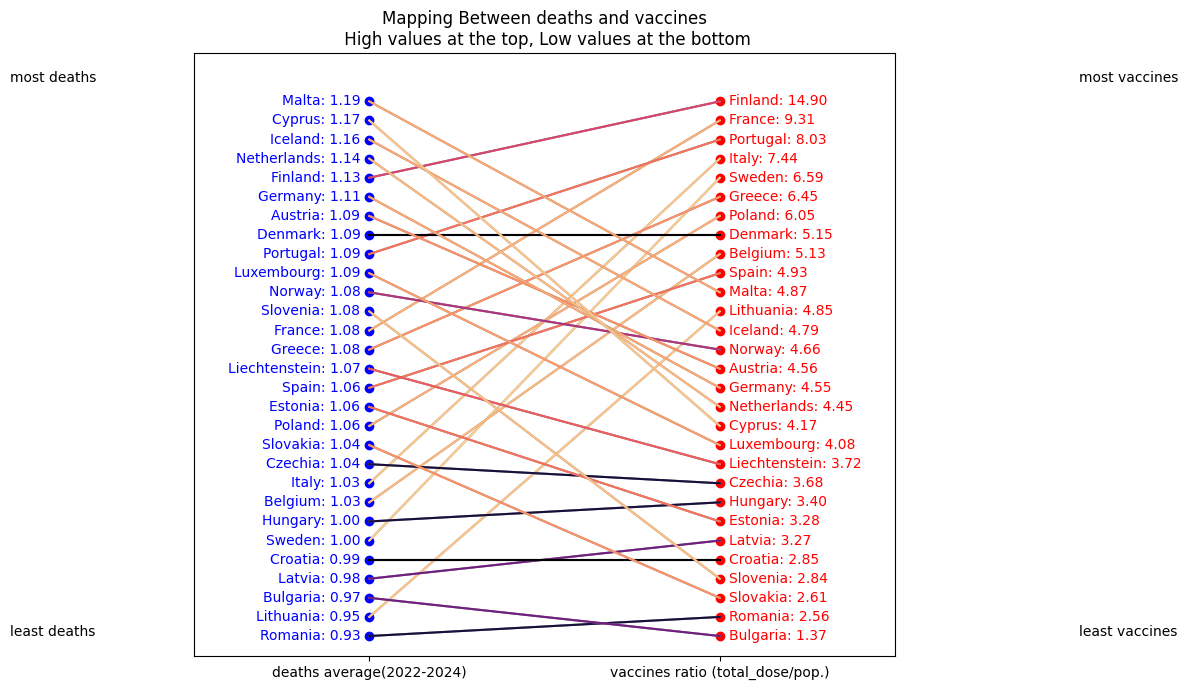

In [92]:

# deaths values with out the NA
d = dxv.copy().dropna(subset=['value'])
d = d.sort_values(by='average(2022-2024)',ascending=True)
d = d.reset_index()

# vaccines values with out the NA
v = dxv.copy().dropna(subset=['value'])
v = v.sort_values(by='value',ascending=True)
v = v.reset_index()
v['rank'] = v['value'].rank()

# making sure the lists have the same values
d = d[d.abbr.isin(v.abbr)]
d = d.reset_index(drop=True)

# display(d)
# display(v)

# Create a plot
fig, ax = plt.subplots(figsize=(14, 7))

ydistance = 0.95

# Plot points for the first dataframe
for i, row in d.iterrows():
    ax.scatter(0, i * ydistance, label=row['name'], color='blue')
    ax.text(-0.025, i * ydistance, row['name'] + ': ' + f"{row['average(2022-2024)']:.2f}", ha='right', va='center', color='blue')

# Plot points for the second dataframe
for i, row in v.iterrows():
    ax.scatter(1, i * ydistance, label=row['name'], color='red')
    ax.text(1.025, i * ydistance, row['name'] + ': ' + f"{row['value']:.2f}", ha='left', va='center', color='red')


ax.text(-0.025 - 1.0, len(v) * ydistance, 'most deaths')
ax.text(-0.025 - 1.0, 0 * ydistance, 'least deaths')

ax.text(1.025 + 1.0, len(v) * ydistance, 'most vaccines')
ax.text(1.025 + 1.0, 0 * ydistance, 'least vaccines')

# Create a colormap
colormap = plt.get_cmap('magma')
norm = Normalize(vmin=-np.pi, vmax=np.pi)

# Draw lines connecting matching abbr values
for name in d['name']:
    if name in v['name'].values:
        idx1 = d[d['name'] == name].index[0] * ydistance
        idx2 = v[v['name'] == name].index[0] * ydistance
        ax.plot([0, 1], [idx1, idx2], color='gray', linestyle='-')
        vertical_diff = idx2 - idx1
        horizontal_diff = 1  # The horizontal distance between the columns
        angle = np.arctan2(vertical_diff, horizontal_diff)  # Calculate the angle

        # normalized_angle = (angle + 2 * np.pi) / (2 * np.pi )  # Normalize angle to [0, 1]
        normalized_angle = pow ( abs(angle / np.pi)/0.5, 3) # custom normalized angle for better colors
        # print(normalized_angle)

        color = colormap(normalized_angle)  # Map normalized angle to a color
        ax.plot([0, 1], [idx1, idx2], color=color, linestyle='-')

# Formatting
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-1, max(len(d), len(v)))
ax.set_xticks([0, 1])
ax.set_xticklabels(['deaths average(2022-2024)', 'vaccines ratio (total_dose/pop.)'])
ax.set_yticks([])
ax.set_title('Mapping Between deaths and vaccines\n High values at the top, Low values at the bottom')
ax.grid(False)
plt.tight_layout()
plt.show()


### Spearman and Kendall

In [93]:
# create a ranked list for deaths - average(2022-2024)
d = dxv.copy().reset_index(drop=True)
d = d.sort_values(by='average(2022-2024)',ascending=False) #most deaths to least deaths
d = d[['name','abbr','average(2022-2024)']]
d['rank'] = d['average(2022-2024)'].rank()

# create a ranked list for vaccines - ratio (total_dose/pop.)
v = dxv.copy().reset_index(drop=True)
v = v.sort_values(by='value',ascending=True) #least vaccine to most vaccines
v = v[['name','abbr','value']]
v['rank'] = v['value'].rank()

# make sure the have the same countries
d = d[d.abbr.isin(v.abbr)]

for i, row in v.iterrows():
    d.loc[d['abbr']==row['abbr'], 'rank'] = row['rank']

# no NAN values
d = d[~d['rank'].isna()]
v = v[~v['rank'].isna()]

display(MD(
'''### Output Interpretation

| Value     | Effect                      | Description/Correlation-Suggestion                         |
|-----------|-----------------------------|------------------------------------------------------------|
| **1.0**   | Positive effect             | Suggests more vaccines will lead to fewer deaths.          |
| **0.5**   | Slightly positive effect    | Slightly suggests more vaccines will lead to fewer deaths. |
| **0.0**   | Null/No effect              | Vaccines do not change the number of deaths.               |
| **-0.5**  | Slightly negative effect    | Slightly suggests more vaccines will lead to more deaths.  |
| **-1.0**  | Negative effect             | Suggests more vaccines will lead to more deaths.           |

'''
))




# Calculate Spearman's Rank Correlation
spearman_corr, _ = spearmanr(d['rank'], v['rank'])
display(MD(f"### Spearman's Rank Correlation: {spearman_corr}"))

display(bar(((spearman_corr+1.0)/2.0)*100,length=100))
display('-1'+' '*48 + '0' + ' '*50 + '1')

# Calculate Kendall's Tau
kendall_corr, _ = kendalltau(d['rank'], v['rank'])
display(MD(f"### Kendall's Tau: {kendall_corr}"))

display(bar(((kendall_corr+1.0)/2.0)*100,length=100))
display('-1'+' '*48 + '0' + ' '*50 + '1')

# display(d)
# display(v)


### Output Interpretation

| Value     | Effect                      | Description/Correlation-Suggestion                         |
|-----------|-----------------------------|------------------------------------------------------------|
| **1.0**   | Positive effect             | Suggests more vaccines will lead to fewer deaths.          |
| **0.5**   | Slightly positive effect    | Slightly suggests more vaccines will lead to fewer deaths. |
| **0.0**   | Null/No effect              | Vaccines do not change the number of deaths.               |
| **-0.5**  | Slightly negative effect    | Slightly suggests more vaccines will lead to more deaths.  |
| **-1.0**  | Negative effect             | Suggests more vaccines will lead to more deaths.           |



### Spearman's Rank Correlation: -0.33990147783251223

'[#################################___________________________________________________________________]'

'-1                                                0                                                  1'

### Kendall's Tau: -0.24630541871921177

'[#####################################_______________________________________________________________]'

'-1                                                0                                                  1'

### Other death x vaccine charts

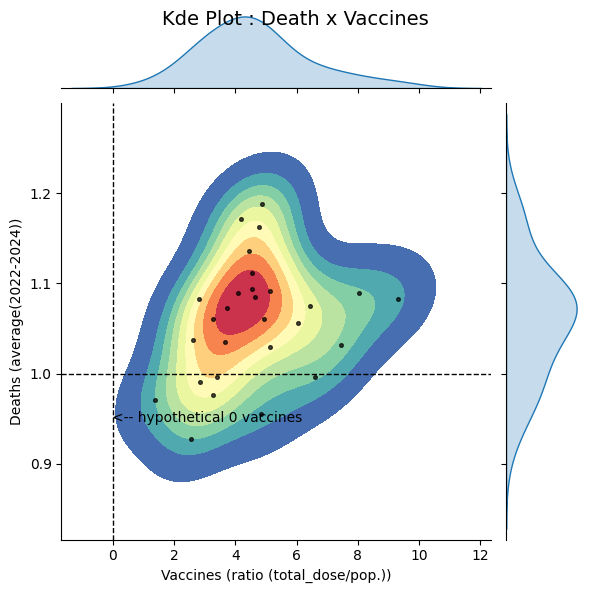

In [ ]:
temp = dxv[dxv.value < 14] #gets rid of the outliar (finland)
temp = temp.dropna(subset=['value'])


    # kde 
g = sns.jointplot(
    data=temp,
    x="value", 
    y="average(2022-2024)", 
    kind="kde",
    fill=True,
    cmap=heatmapCM
)

# Add scatter points on top
g.ax_joint.scatter(
    temp["value"], 
    temp['average(2022-2024)'], 
    color="black", 
    alpha=0.7, 
    s=7
)


g.set_axis_labels( "Vaccines (ratio (total_dose/pop.))","Deaths (average(2022-2024))")

g.figure.suptitle("Kde Plot : Death x Vaccines", fontsize=14)

# Add a title
plt.title("<-- hypothetical 0 vaccines", fontsize=10,x=0.34,y=0.25)

# Add vertical and horizontal lines
plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1)  # Vertical line at x=20
plt.axhline(y=1.0, color='black', linestyle='--', linewidth=1)  # Horizontal line at y=3

# display(vdravg)
plt.show()


In [95]:
title = 'Scatter Chart - Death x Vaccine'
display(MD(f'### {title}'))

fig = px.scatter(
        dxv,
        x="value",      
        y="average(2022-2024)",       
        color="name",      
        hover_name="name",
        title=title,
        labels={
            "value": "Vaccines (ratio total_dose/pop.)",  # Custom X-axis label
            "average(2022-2024)": "Deaths average(2022-2024)"           # Custom Y-axis label
        },
        height=750
    )
fig.update_layout(template="plotly_dark")

fig.add_shape(
    type="line",
    x0=0, x1=dxv.value.max(),
    y0=1, y1=1, # Start and end y-coordinates
    line=dict(color="Red", width=2, dash="dash"),  # Line style
    xref="x", yref="y"          # Reference axes
)


fig.show()

### Scatter Chart - Death x Vaccine

### Bad-Batch Theory 
#### There seems to be to be an unusual grouping/cluster
Where countries that have a vaccine (ratio total_dose/pop.) between 4.0-6.0, have an unusually high Deaths average(2022-2024) above 1.1.

#### Bad-Batch Theory (by Dr Vibeke Manniche)
A study in European Journal of Clinical Investigation found significant batch-dependent variations in adverse event reports for the Pfizer-BioNTech COVID-19 vaccine in Denmark (2020–2022),  
suggesting some batches had higher reported risks. Further investigation is needed.

* The Paper
    * [Batch-dependent safety of the BNT162b2 mRNA COVID-19 vaccine - by Dr Vibeke Manniche ](https://onlinelibrary.wiley.com/doi/10.1111/eci.13998)
* An Interview 
    * [Excess deaths, the silence - Dr John Campbell and Dr Vibeke Manniche (Youtube)](https://www.youtube.com/watch?v=nD--4tLmb3w)

* <img src='./docs/chrome_vTKng4rNsY.png' alt="." height="500px"/>  
* <img src='./chrome_vTKng4rNsY.png' alt="." style="height: 500px; width: auto;"/>
* <img src='./docs/eci13998-fig-0001-m.jpg' alt="." height="350px"/>  
* <img src='./eci13998-fig-0001-m.jpg' alt="." style="height: 350px; width: auto;"/>

#### my 2 cents
This is not suprising, the vaccine was created in a rushed manner ... and as a rule of thumb, `Haste Makes Waste`
* Ford Pinto (1971-1980)
* Windows Vista
* Samsung Galaxy Note 7 
* Boeing 737 MAX
* ... and so many more


## Lets look at some of the Causes of Death
note:  
this data only does to 2023-ish.  
with this limited amount of post-pandemic data  
... it will be difficult to draw any meaningful conclusions.  


In [96]:
title = 'Line Chart - normalized causes of death in Europe (by year)'
display(MD(f'### {title}'))

temp = cd[(cd['source']=='cause_of_death') & (~(cd['filter']=='TOTAL')) & (cd['value_type']=='normalized')]

temp = pd.pivot_table(
        data = temp,
        values = 'value',
        index = ['filter'],
        columns=['year'],
        aggfunc='mean',
    )
temp = temp.reset_index()

# temp['average(2021-2022)'] = (temp[2021]+temp[2022])/2.0
years = [i for i in range(2015,2023)]

# temp['stdev'] = temp[[2020,2021,2022]].std(axis=1)
# temp = temp.sort_values(by='stdev', ascending=False)

temp = temp.sort_values(by=2022, ascending=False)
display(temp.style.background_gradient(cmap=heatmapCM,axis=1,subset=years))



### Line Chart - normalized causes of death in Europe (by year)

year,filter,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000,2022.000000,2023.000000
7,Diseases of the skin and subcutaneous tissue (L00-L99),0.952700,0.988986,1.058314,1.075503,1.193232,1.258299,1.297455,1.591110,0.319839
12,"Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)",0.995540,0.984867,1.019594,1.057114,1.219432,1.518470,1.339570,1.476779,0.290196
10,Mental and behavioural disorders (F00-F99),0.931040,0.976116,1.092844,1.178312,1.225431,1.289635,1.347351,1.396606,0.221782
8,"Endocrine, nutritional and metabolic diseases (E00-E90)",0.973747,0.979490,1.046763,1.070362,1.107944,1.249651,1.314197,1.272323,0.225376
4,Diseases of the genitourinary system (N00-N99),0.992709,0.980498,1.026793,1.055125,1.045159,1.131820,1.178126,1.237250,0.273888
5,Diseases of the musculoskeletal system and connective tissue (M00-M99),0.995449,0.958319,1.046231,1.105399,1.118685,1.068406,1.097093,1.139465,0.204976
3,Diseases of the digestive system (K00-K93),0.988721,0.996419,1.014860,1.013569,1.038691,1.060206,1.109400,1.122434,0.222949
6,Diseases of the respiratory system (J00-J99),0.991490,0.960160,1.048350,1.064795,1.023761,0.980327,0.985675,1.059276,0.222002
9,Malignant neoplasms (C00-C97),0.994287,1.002868,1.002845,1.009227,1.008936,1.008924,0.992634,0.995533,0.196705
2,Diseases of the circulatory system (I00-I99),1.021408,0.986229,0.992363,0.971170,0.947074,0.966720,0.980255,0.969827,0.181271


### Hypothesizing Adverse Reactions from an mRNA Vaccine  

1. **Blood Issues**  
   * Since the vaccine is injected into the body, potential blood-related adverse reactions should be considered.  

2. **Heart Issues**  
   * Based on reports and concerns about myocarditis and pericarditis.  

3. **DNA / Cancer Concerns (AKA Neoplasm)**  
   * **Innate immune suppression by SARS-CoV-2 mRNA vaccinations: The role of G-quadruplexes, exosomes, and MicroRNAs**
      * A study suggests mRNA vaccines may suppress innate immunity by affecting type I interferon signaling, potentially increasing the risk of **neurodegenerative diseases, myocarditis, immune disorders, and cancer**.  
         - **Source:** [Innate immune suppression by SARS-CoV-2 mRNA vaccinations: The role of G-quadruplexes, exosomes, and MicroRNAs](https://pmc.ncbi.nlm.nih.gov/articles/PMC9012513/)  
         - **From:** National Library of Medicine
         - **Authors:** Stephanie Seneff, Greg Nigh, Anthony M. Kyriakopoulos, Peter A. McCullough  
   * **Reverse-transcribed SARS-CoV-2 RNA can integrate into the genome of cultured human cells and can be expressed in patient-derived tissues**
      * The study investigates whether RNA from the SARS-CoV-2 virus (the virus causing COVID-19) can be reverse-transcribed into DNA and integrated into the human genome.
         - **Source:** [Reverse-transcribed SARS-CoV-2 RNA can integrate into the genome of cultured human cells and can be expressed in patient-derived tissues](https://www.pnas.org/doi/10.1073/pnas.2105968118)
         - **From:** Proceedings of the National Academy of Sciences (PNAS)
         - **Authors:** Liguo Zhang, Alexsia Richards, M. Inmaculada Barrasa, Stephen H. Hughes, Richard A. Young, and Rudolf Jaenisch


4. **Unknown Issues**  
   * As a new medication, unforeseen adverse reactions may arise.  


#### Spearman and Kendall ... (again)

In [97]:
# create a ranked list for vaccines - ratio (total_dose/pop.)

v = dxv.copy().reset_index(drop=True)
v = v.rename(columns={'value': 'vaccines | ratio (total_dose/pop.)'})
v = v[~v['vaccines | ratio (total_dose/pop.)'].isna()]
v = v.sort_values(by='vaccines | ratio (total_dose/pop.)',ascending=True) #least vaccine to most vaccines
v = v[['name','abbr','vaccines | ratio (total_dose/pop.)']]
v['rank'] = v['vaccines | ratio (total_dose/pop.)'].rank()
# display(v)

cods = cd[(cd.source == 'cause_of_death') & (cd.value_type == 'normalized') & (cd['year'] == 2022) & (~cd.value.isna()) & (~(cd['filter'] == 'Total')) ]['filter'].drop_duplicates().to_list()


result = []
for c in cods:
    # print(c)

    temp = pd.pivot_table(
        data = cd[(cd['filter'] == c) & (cd.value_type == 'normalized') & (cd['year'] == 2022)],
        values = 'value',
        index = ['name','abbr'],
        columns=['year'],
        aggfunc='mean',
    )
    temp = temp.reset_index()

    temp = temp.sort_values(by=2022,ascending=False) #most deaths to least deaths
    temp['rank'] = temp[2022].rank()
    # display(temp)

    temp = temp[temp.abbr.isin(v.abbr)]
    vtemp = v[v.abbr.isin(temp.abbr)]

    for i, row in vtemp.iterrows():
        temp.loc[temp['abbr']==row['abbr'], 'rank'] = row['rank']

    result.append(
        {
            'cause_of_death': c,
            'Spearman_Rank': spearmanr(temp['rank'], vtemp['rank'])[0],
            'Kendall_Tau': kendalltau(temp['rank'], vtemp['rank'])[0]
        }
    )

    # display(temp)
    # display(vtemp)

    # display(MD(f"## {c} x Vaccines"))
    # # Calculate Spearman's Rank Correlation
    # spearman_corr, _ = spearmanr(temp['rank'], vtemp['rank'])
    # display(MD(f"### Spearman's Rank Correlation: {spearman_corr}"))

    # display(bar(((spearman_corr+1.0)/2.0)*100,length=100))
    # display('-1'+' '*48 + '0' + ' '*50 + '1')

    # # Calculate Kendall's Tau
    # kendall_corr, _ = kendalltau(temp['rank'], v['rank'])
    # display(MD(f"### Kendall's Tau: {kendall_corr}"))

    # display( bar(((kendall_corr+1.0)/2.0)*100,length=100))
    # display('-1'+' '*48 + '0' + ' '*50 + '1')

display(MD(
'''### Output Interpretation

| Value     | Effect                      | Description/Correlation-Suggestion                                   |
|-----------|-----------------------------|----------------------------------------------------------------------|
| **1.0**   | Positive effect             | Suggests more vaccines will lead to fewer [cause of death].          |
| **0.5**   | Slightly positive effect    | Slightly suggests more vaccines will lead to fewer [cause of death]. |
| **0.0**   | Null/No effect              | Vaccines do not change the number of [cause of death].               |
| **-0.5**  | Slightly negative effect    | Slightly suggests more vaccines will lead to more [cause of death].  |
| **-1.0**  | Negative effect             | Suggests more vaccines will lead to more [cause of death].           |

'''
))

result = pd.DataFrame(result)
result = result.sort_values(by='Spearman_Rank')
result = result.reset_index(drop=True)

display(MD("#### lets point out how many causes of death's increased with the number of vaccines"))
display(MD(f"* {len(result[result['Spearman_Rank'] <= -0.3])} with a Spearman_Rank less than -0.3"))
display(MD(f"* {len(result[result['Spearman_Rank'] >= 0.3])} with a Spearman_Rank greater than 0.3"))

display(result.style.background_gradient(cmap=heatmapCM4)) #,vmax=1.0,vmin=-1.0))

# lets dataframe the top and bottom causes of death
TB_cod = pd.concat([result[result['Spearman_Rank'] <= -0.3],result[result['Spearman_Rank'] >= 0.3]])


### Output Interpretation

| Value     | Effect                      | Description/Correlation-Suggestion                                   |
|-----------|-----------------------------|----------------------------------------------------------------------|
| **1.0**   | Positive effect             | Suggests more vaccines will lead to fewer [cause of death].          |
| **0.5**   | Slightly positive effect    | Slightly suggests more vaccines will lead to fewer [cause of death]. |
| **0.0**   | Null/No effect              | Vaccines do not change the number of [cause of death].               |
| **-0.5**  | Slightly negative effect    | Slightly suggests more vaccines will lead to more [cause of death].  |
| **-1.0**  | Negative effect             | Suggests more vaccines will lead to more [cause of death].           |



#### lets point out how many causes of death's increased with the number of vaccines

* 2 with a Spearman_Rank less than -0.3

* 1 with a Spearman_Rank greater than 0.3

,cause_of_death,Spearman_Rank,Kendall_Tau
0,Malignant neoplasms (C00-C97),-0.459223,-0.317460
1,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",-0.435140,-0.312169
2,"Pregnancy, childbirth and the puerperium (O00-O99)",-0.200870,-0.166667
3,Diseases of the genitourinary system (N00-N99),-0.160920,-0.079365
4,Mental and behavioural disorders (F00-F99),-0.149973,-0.089947
5,"Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)",-0.110016,-0.052910
6,Diseases of the musculoskeletal system and connective tissue (M00-M99),-0.110016,-0.068783
7,Diseases of the skin and subcutaneous tissue (L00-L99),-0.085933,-0.047619
8,"Endocrine, nutritional and metabolic diseases (E00-E90)",-0.032841,-0.010582
9,Diseases of the digestive system (K00-K93),-0.007663,0.000000


## lets see these overtime

In [98]:

# lets also filter by the top 10 most and least 10 vaccinated countries
v = dxv.copy().reset_index(drop=True)
v = v.sort_values(by='value',ascending=False) #least vaccine to most vaccines
v = v[~v['value'].isna()]
include_abbr = pd.concat([v.head(5),v.tail(5)]).abbr.to_list()

# let's print this lists for reference
display(v.head(5))
display(v.tail(5))

for index,row in TB_cod.iterrows():
    print(index,row)

    temp = cd[(cd['source']=='cause_of_death') & (cd['filter'] == row['cause_of_death']) & (cd['value_type']=='normalized') & (cd['year'] < 2023)]
    temp = temp[temp['abbr'].isin(include_abbr)]

    ## adding the vaccine value (ratio (total_dose/pop.))
    temp['vac dose/pop.'] = 0.0
    for i, vrow in v.iterrows():
        mask = temp['abbr'] == vrow['abbr']  # Create a boolean mask
        temp.loc[mask, 'vac dose/pop.'] = vrow['value']

    temp = temp.sort_values(by=['year', 'name'], ascending=[True, True])

    fig = px.line(
        temp,
        x='year',
        y='value',
        color='name',
        height=750 ,
        hover_data={
            'name', 'abbr', 'value','vac dose/pop.'
        },
        title=f"cause_of_death \'{row['cause_of_death']}\' , Spearman_Rank {row['Spearman_Rank']}"
        )
    fig.update_layout(template="plotly_dark")
    fig.add_shape(
        type="line",
        x0=2015, x1=2022,
        y0=1, y1=1, # Start and end y-coordinates
        line=dict(color="Red", width=2, dash="dash"),  # Line style
        xref="x", yref="y"          # Reference axes
    )
    fig.show()



,name,abbr,filter_x,value_type_x,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,average(2022-2024),source,filter_y,value_type_y,value
0,Finland,FI,TOTAL,normalized,0.996,1.004,1.000,1.017,1.005,1.052,1.077,1.156,1.143,1.078,1.126,vaccine,All,ratio (total_dose/pop.),14.897
1,France,FR,TOTAL,normalized,1.008,0.985,1.007,1.013,1.019,1.132,1.099,1.122,1.062,1.062,1.082,vaccine,All,ratio (total_dose/pop.),9.312
2,Portugal,PT,TOTAL,normalized,1.006,1.000,0.994,1.025,1.013,1.140,1.129,1.127,1.072,1.068,1.089,vaccine,All,ratio (total_dose/pop.),8.030
3,Italy,IT,TOTAL,normalized,1.028,0.960,1.011,0.984,0.990,1.165,1.087,1.095,1.014,0.986,1.032,vaccine,All,ratio (total_dose/pop.),7.442
4,Sweden,SE,TOTAL,normalized,1.019,0.986,0.995,0.995,0.957,1.079,0.986,1.012,1.006,0.970,0.996,vaccine,All,ratio (total_dose/pop.),6.590


,name,abbr,filter_x,value_type_x,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,average(2022-2024),source,filter_y,value_type_y,value
24,Croatia,HR,TOTAL,normalized,1.036,0.963,1.001,0.988,0.970,1.089,1.174,1.067,0.960,0.947,0.991,vaccine,All,ratio (total_dose/pop.),2.854
25,Slovenia,SI,TOTAL,normalized,1.006,0.976,1.018,1.018,1.024,1.216,1.151,1.118,1.070,1.061,1.083,vaccine,All,ratio (total_dose/pop.),2.835
26,Slovakia,SK,TOTAL,normalized,1.023,0.973,1.004,1.012,0.993,1.126,1.364,1.109,1.008,0.995,1.038,vaccine,All,ratio (total_dose/pop.),2.609
27,Romania,RO,TOTAL,normalized,1.021,0.982,0.998,1.005,0.994,1.151,1.276,1.027,0.918,0.838,0.928,vaccine,All,ratio (total_dose/pop.),2.558
28,Bulgaria,BG,TOTAL,normalized,1.024,0.978,0.998,0.988,0.985,1.150,1.358,1.080,0.919,0.912,0.970,vaccine,All,ratio (total_dose/pop.),1.370


0 cause_of_death    Malignant neoplasms (C00-C97)
Spearman_Rank                            -0.459
Kendall_Tau                              -0.317
Name: 0, dtype: object


1 cause_of_death    Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)
Spearman_Rank                                                                             -0.435
Kendall_Tau                                                                               -0.312
Name: 1, dtype: object


12 cause_of_death    Diseases of the respiratory system (J00-J99)
Spearman_Rank                                            0.307
Kendall_Tau                                              0.212
Name: 12, dtype: object


In [99]:


temp = cd[(cd['source']=='cause_of_death') & (cd['value_type']=='normalized')]

codlist = ['Malignant neoplasms (C00-C97)','Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)','Diseases of the respiratory system (J00-J99)']
temp = temp[temp['filter'].isin(codlist)]

temp = pd.pivot_table(
    data = temp,
    values = 'value',
    index = ['abbr','name','filter','value_type'],
    columns=['year'],
    aggfunc='mean',
)
temp.columns.name = 'index' 
temp = temp.reset_index()

## vaccines in 2023
v2023 = cd[(cd['source']=='vaccine') & (cd['filter']=='All') & (cd['value_type']=='ratio (total_dose/pop.)') & (cd['year'] == 2023)]
v2023 = v2023[['name','source','filter','value_type','value']]

# adding it to the temp
temp = pd.merge(temp,v2023, how='left',on='name')


for c in codlist:
    display(MD(f'### {c}'))
    temp2 = temp[temp['filter_x']==c]
    temp2 = temp2.sort_values(by=2022,ascending=False)

    styled_df = temp2.style.background_gradient(cmap=heatmapCM2, axis=1, subset=[i for i in range(2015,2023)]) \
                        .background_gradient(cmap=heatmapCM3, axis=0, subset=['value'])
    
    display(MD('#### sorted by 2022 column'))
    display(styled_df)
    
    temp2 = temp2.sort_values(by='value',ascending=False)

    styled_df = temp2.style.background_gradient(cmap=heatmapCM2, axis=1, subset=[i for i in range(2015,2023)]) \
                        .background_gradient(cmap=heatmapCM3, axis=0, subset=['value'])
    
    display(MD('#### sorted by value (ratio (total_dose/pop.))'))
    display(styled_df)

# we will use this in a cell below
codxv = temp.copy()

### Malignant neoplasms (C00-C97)

#### sorted by 2022 column

,abbr,name,filter_x,value_type_x,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000,2022.000000,2023.000000,source,filter_y,value_type_y,value
14,CY,Cyprus,Malignant neoplasms (C00-C97),normalized,0.991532,0.951183,1.057285,1.068493,1.072229,1.133499,1.188045,1.117808,0.000000,vaccine,All,ratio (total_dose/pop.),4.173517
47,IE,Ireland,Malignant neoplasms (C00-C97),normalized,0.979477,1.011917,1.008606,1.021516,1.056383,1.064548,1.063886,1.114421,0.000000,vaccine,All,ratio (total_dose/pop.),5.379732
65,MT,Malta,Malignant neoplasms (C00-C97),normalized,0.988223,0.994647,1.017131,1.119914,1.016060,1.077088,1.046039,1.099572,0.000000,vaccine,All,ratio (total_dose/pop.),4.872870
50,IS,Iceland,Malignant neoplasms (C00-C97),normalized,0.964978,1.084591,0.950431,0.934267,1.021552,1.005388,0.995690,1.087823,1.076509,vaccine,All,ratio (total_dose/pop.),4.790077
35,FI,Finland,Malignant neoplasms (C00-C97),normalized,0.980161,1.006497,1.013343,1.012135,1.039357,1.047572,1.060377,1.053854,0.000000,vaccine,All,ratio (total_dose/pop.),14.897412
2,AT,Austria,Malignant neoplasms (C00-C97),normalized,1.004749,0.995967,0.999284,1.013433,1.012262,1.031582,1.018751,1.041828,1.038022,vaccine,All,ratio (total_dose/pop.),4.559281
71,NO,Norway,Malignant neoplasms (C00-C97),normalized,0.991960,1.001995,1.006045,1.005861,0.999417,1.002639,1.007702,1.041121,0.000000,vaccine,All,ratio (total_dose/pop.),4.657366
77,PT,Portugal,Malignant neoplasms (C00-C97),normalized,0.980787,1.006920,1.012293,1.027973,1.050609,1.045051,1.017483,1.028120,0.000000,vaccine,All,ratio (total_dose/pop.),8.030406
32,ES,Spain,Malignant neoplasms (C00-C97),normalized,0.989611,1.003440,1.006949,1.001899,1.005047,1.001963,1.009764,1.021535,1.027951,vaccine,All,ratio (total_dose/pop.),4.926581
68,NL,Netherlands,Malignant neoplasms (C00-C97),normalized,0.986301,1.011021,1.002677,0.999473,1.007528,1.006549,1.006104,1.018831,0.000000,vaccine,All,ratio (total_dose/pop.),4.448430


#### sorted by value (ratio (total_dose/pop.))

,abbr,name,filter_x,value_type_x,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000,2022.000000,2023.000000,source,filter_y,value_type_y,value
35,FI,Finland,Malignant neoplasms (C00-C97),normalized,0.980161,1.006497,1.013343,1.012135,1.039357,1.047572,1.060377,1.053854,0.000000,vaccine,All,ratio (total_dose/pop.),14.897412
38,FR,France,Malignant neoplasms (C00-C97),normalized,0.991905,1.004069,1.004026,0.997865,1.002613,1.001065,0.995754,1.007122,0.000000,vaccine,All,ratio (total_dose/pop.),9.311581
77,PT,Portugal,Malignant neoplasms (C00-C97),normalized,0.980787,1.006920,1.012293,1.027973,1.050609,1.045051,1.017483,1.028120,0.000000,vaccine,All,ratio (total_dose/pop.),8.030406
53,IT,Italy,Malignant neoplasms (C00-C97),normalized,0.999683,0.999372,1.000945,1.001978,0.994882,0.987206,0.969412,0.967980,0.000000,vaccine,All,ratio (total_dose/pop.),7.442137
86,SE,Sweden,Malignant neoplasms (C00-C97),normalized,0.989690,0.996485,1.013825,0.995911,0.993396,0.997676,0.980910,0.993352,0.000000,vaccine,All,ratio (total_dose/pop.),6.589887
29,EL,Greece,Malignant neoplasms (C00-C97),normalized,0.993818,1.006138,1.000045,0.995358,1.004229,1.010891,1.007577,0.966031,0.000000,vaccine,All,ratio (total_dose/pop.),6.445362
74,PL,Poland,Malignant neoplasms (C00-C97),normalized,1.005447,0.998825,0.995728,1.012948,1.002550,0.997746,0.935670,0.960480,0.000000,vaccine,All,ratio (total_dose/pop.),6.050301
47,IE,Ireland,Malignant neoplasms (C00-C97),normalized,0.979477,1.011917,1.008606,1.021516,1.056383,1.064548,1.063886,1.114421,0.000000,vaccine,All,ratio (total_dose/pop.),5.379732
23,DK,Denmark,Malignant neoplasms (C00-C97),normalized,0.987781,1.011301,1.000919,1.003931,1.032706,1.011749,1.031360,1.011621,0.000000,vaccine,All,ratio (total_dose/pop.),5.147361
5,BE,Belgium,Malignant neoplasms (C00-C97),normalized,1.008534,1.008903,0.982563,0.977000,0.983594,0.967091,0.965801,0.971511,0.000000,vaccine,All,ratio (total_dose/pop.),5.129494


### Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)

#### sorted by 2022 column

,abbr,name,filter_x,value_type_x,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000,2022.000000,2023.000000,source,filter_y,value_type_y,value
12,CY,Cyprus,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,0.933333,1.133333,0.933333,0.533333,1.666667,1.066667,1.400000,1.466667,0.000000,vaccine,All,ratio (total_dose/pop.),4.173517
45,IE,Ireland,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,1.049080,0.926380,1.024540,1.104294,1.233129,1.141104,1.098160,1.190184,0.000000,vaccine,All,ratio (total_dose/pop.),5.379732
18,DE,Germany,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,0.925963,1.018763,1.055274,1.085700,1.061359,1.032454,1.081643,1.152637,0.000000,vaccine,All,ratio (total_dose/pop.),4.547240
87,SI,Slovenia,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,0.728972,1.205607,1.065421,1.261682,1.345794,1.065421,1.065421,1.149533,0.000000,vaccine,All,ratio (total_dose/pop.),2.835063
3,BE,Belgium,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,0.947814,1.095910,0.956276,1.315938,1.121298,1.002821,0.875882,1.108604,0.000000,vaccine,All,ratio (total_dose/pop.),5.129494
75,PT,Portugal,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,1.049734,0.953819,0.996448,1.246892,1.278863,1.087034,1.134991,1.076377,0.000000,vaccine,All,ratio (total_dose/pop.),8.030406
33,FI,Finland,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,0.886239,1.078899,1.034862,0.963303,0.935780,0.941284,1.056881,1.073394,0.000000,vaccine,All,ratio (total_dose/pop.),14.897412
30,ES,Spain,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,0.977254,1.030869,0.991877,1.027214,0.993095,1.002843,1.015028,1.050366,1.012591,vaccine,All,ratio (total_dose/pop.),4.926581
9,CH,Switzerland,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,1.030508,1.010169,0.959322,0.847458,0.888136,0.830508,0.820339,1.040678,0.000000,nan,nan,nan,nan
84,SE,Sweden,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,0.807259,1.073842,1.118899,1.122653,0.987484,1.025031,0.976220,1.040050,0.000000,vaccine,All,ratio (total_dose/pop.),6.589887


#### sorted by value (ratio (total_dose/pop.))

,abbr,name,filter_x,value_type_x,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000,2022.000000,2023.000000,source,filter_y,value_type_y,value
33,FI,Finland,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,0.886239,1.078899,1.034862,0.963303,0.935780,0.941284,1.056881,1.073394,0.000000,vaccine,All,ratio (total_dose/pop.),14.897412
36,FR,France,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,1.017804,1.008309,0.973887,0.900297,0.960237,0.897923,0.900890,0.999407,0.000000,vaccine,All,ratio (total_dose/pop.),9.311581
75,PT,Portugal,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,1.049734,0.953819,0.996448,1.246892,1.278863,1.087034,1.134991,1.076377,0.000000,vaccine,All,ratio (total_dose/pop.),8.030406
51,IT,Italy,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,1.039006,0.918261,1.042733,0.980870,0.948820,1.005466,0.983106,0.975652,0.000000,vaccine,All,ratio (total_dose/pop.),7.442137
84,SE,Sweden,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,0.807259,1.073842,1.118899,1.122653,0.987484,1.025031,0.976220,1.040050,0.000000,vaccine,All,ratio (total_dose/pop.),6.589887
27,EL,Greece,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,0.862559,1.127962,1.009479,0.872038,0.928910,1.071090,0.848341,0.886256,0.000000,vaccine,All,ratio (total_dose/pop.),6.445362
72,PL,Poland,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,0.981561,0.970969,1.047470,1.043939,0.927423,0.915653,0.993331,0.939192,0.000000,vaccine,All,ratio (total_dose/pop.),6.050301
45,IE,Ireland,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,1.049080,0.926380,1.024540,1.104294,1.233129,1.141104,1.098160,1.190184,0.000000,vaccine,All,ratio (total_dose/pop.),5.379732
21,DK,Denmark,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,0.946988,1.026506,1.026506,1.091566,0.932530,1.055422,0.881928,0.939759,0.000000,vaccine,All,ratio (total_dose/pop.),5.147361
3,BE,Belgium,"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",normalized,0.947814,1.095910,0.956276,1.315938,1.121298,1.002821,0.875882,1.108604,0.000000,vaccine,All,ratio (total_dose/pop.),5.129494


### Diseases of the respiratory system (J00-J99)

#### sorted by 2022 column

,abbr,name,filter_x,value_type_x,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000,2022.000000,2023.000000,source,filter_y,value_type_y,value
91,SK,Slovakia,Diseases of the respiratory system (J00-J99),normalized,1.021516,0.890940,1.087544,1.026846,0.966147,1.181405,2.025563,1.594157,1.340111,vaccine,All,ratio (total_dose/pop.),2.608904
64,MT,Malta,Diseases of the respiratory system (J00-J99),normalized,0.986072,0.941504,1.072423,1.089136,1.284123,1.200557,1.253482,1.456825,0.000000,vaccine,All,ratio (total_dose/pop.),4.872870
79,RO,Romania,Diseases of the respiratory system (J00-J99),normalized,0.997274,0.968615,1.034111,1.138241,1.181262,1.426691,1.592194,1.340648,0.000000,vaccine,All,ratio (total_dose/pop.),2.557969
7,BG,Bulgaria,Diseases of the respiratory system (J00-J99),normalized,0.929681,1.018976,1.051343,1.120897,0.965261,1.379141,1.567144,1.282730,0.000000,vaccine,All,ratio (total_dose/pop.),1.370123
82,RS,Serbia,Diseases of the respiratory system (J00-J99),normalized,1.055686,0.925837,1.018478,0.996646,1.044865,1.274758,1.366260,1.248560,0.000000,nan,nan,nan,nan
49,IS,Iceland,Diseases of the respiratory system (J00-J99),normalized,0.836735,0.948980,1.214286,1.163265,0.857143,0.923469,0.933673,1.229592,1.040816,vaccine,All,ratio (total_dose/pop.),4.790077
73,PL,Poland,Diseases of the respiratory system (J00-J99),normalized,0.989726,0.938055,1.072220,1.123850,1.109924,1.171204,1.147222,1.226214,0.000000,vaccine,All,ratio (total_dose/pop.),6.050301
25,EE,Estonia,Diseases of the respiratory system (J00-J99),normalized,0.980036,1.007260,1.012704,1.194192,1.088929,0.932849,1.121597,1.136116,0.000000,vaccine,All,ratio (total_dose/pop.),3.277817
16,CZ,Czechia,Diseases of the respiratory system (J00-J99),normalized,0.988986,0.945151,1.065862,1.101009,1.085739,1.097718,1.027424,1.127731,1.140632,vaccine,All,ratio (total_dose/pop.),3.676542
61,LV,Latvia,Diseases of the respiratory system (J00-J99),normalized,0.898739,1.037395,1.063866,1.162185,0.984454,0.901261,0.983193,1.123109,0.000000,vaccine,All,ratio (total_dose/pop.),3.267880


#### sorted by value (ratio (total_dose/pop.))

,abbr,name,filter_x,value_type_x,2015.000000,2016.000000,2017.000000,2018.000000,2019.000000,2020.000000,2021.000000,2022.000000,2023.000000,source,filter_y,value_type_y,value
34,FI,Finland,Diseases of the respiratory system (J00-J99),normalized,0.944544,1.039681,1.015775,1.088958,0.961132,0.854285,0.860628,0.946495,0.000000,vaccine,All,ratio (total_dose/pop.),14.897412
37,FR,France,Diseases of the respiratory system (J00-J99),normalized,0.995234,0.962637,1.042129,1.050499,1.059961,0.901281,0.846249,1.049755,0.000000,vaccine,All,ratio (total_dose/pop.),9.311581
76,PT,Portugal,Diseases of the respiratory system (J00-J99),normalized,1.016271,1.016573,0.967155,1.003823,0.923698,0.849835,0.774992,0.916681,0.000000,vaccine,All,ratio (total_dose/pop.),8.030406
52,IT,Italy,Diseases of the respiratory system (J00-J99),normalized,0.980644,0.940604,1.078753,1.046090,1.084513,1.154365,0.914167,1.024463,0.000000,vaccine,All,ratio (total_dose/pop.),7.442137
85,SE,Sweden,Diseases of the respiratory system (J00-J99),normalized,0.989235,0.969670,1.041095,1.083795,0.959267,0.862378,0.788624,0.962838,0.000000,vaccine,All,ratio (total_dose/pop.),6.589887
28,EL,Greece,Diseases of the respiratory system (J00-J99),normalized,1.047398,0.974959,0.977642,0.894401,0.959568,0.887906,0.923419,0.929491,0.000000,vaccine,All,ratio (total_dose/pop.),6.445362
73,PL,Poland,Diseases of the respiratory system (J00-J99),normalized,0.989726,0.938055,1.072220,1.123850,1.109924,1.171204,1.147222,1.226214,0.000000,vaccine,All,ratio (total_dose/pop.),6.050301
46,IE,Ireland,Diseases of the respiratory system (J00-J99),normalized,0.977738,0.995446,1.026815,1.024791,0.994182,0.827473,0.810018,0.980015,0.000000,vaccine,All,ratio (total_dose/pop.),5.379732
22,DK,Denmark,Diseases of the respiratory system (J00-J99),normalized,0.965601,0.985910,1.048489,1.118829,1.008366,0.934724,0.987726,1.038417,0.000000,vaccine,All,ratio (total_dose/pop.),5.147361
4,BE,Belgium,Diseases of the respiratory system (J00-J99),normalized,1.008991,0.955891,1.035118,1.108343,1.041629,0.884865,0.778579,0.988275,0.000000,vaccine,All,ratio (total_dose/pop.),5.129494


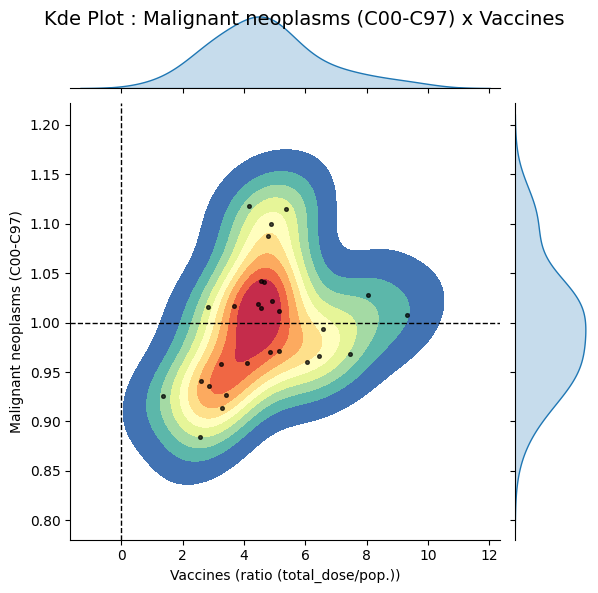

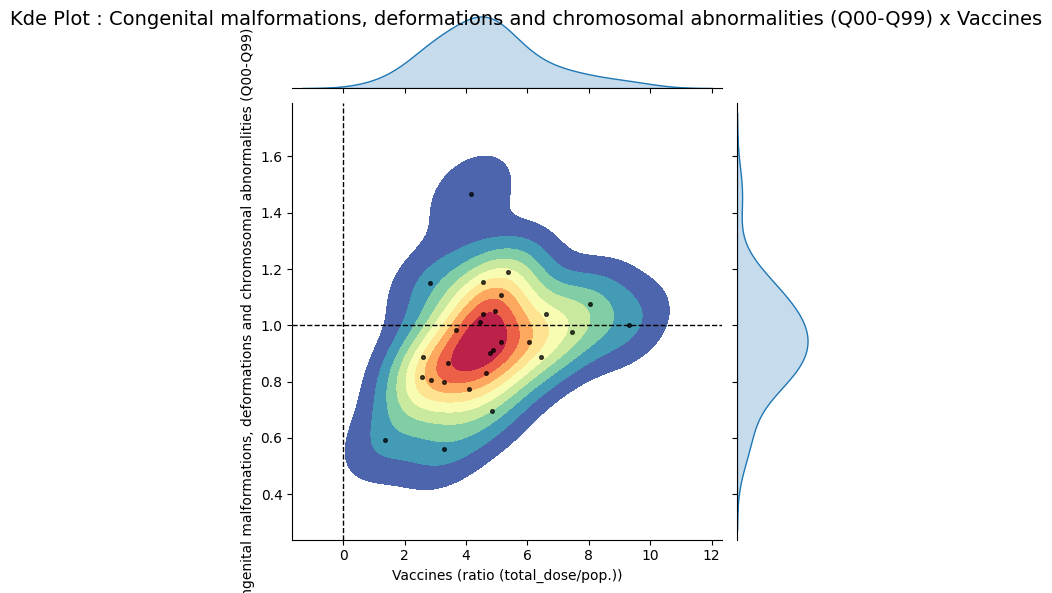

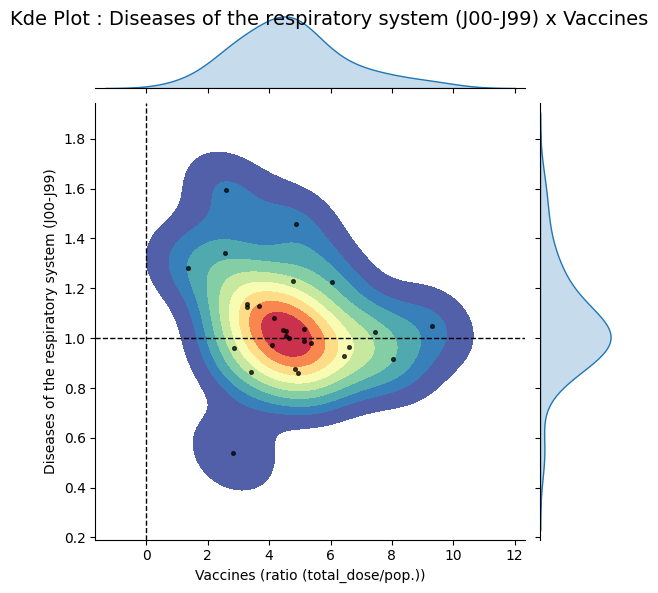

In [100]:

# codxv
temp = codxv[codxv.value < 14].copy()
temp = temp.dropna(subset=['value'])
# display(temp)


codlist = ['Malignant neoplasms (C00-C97)','Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)','Diseases of the respiratory system (J00-J99)']
for c in codlist:

    # kde 
    g = sns.jointplot(
        data=temp[temp['filter_x'] == c],
        x="value", 
        y=2022, 
        kind="kde",
        fill=True,
        cmap=heatmapCM
    )

    # Add scatter points on top
    g.ax_joint.scatter(
        temp[temp['filter_x'] == c]["value"], 
        temp[temp['filter_x'] == c][2022], 
        color="black", 
        alpha=0.7, 
        s=7
    )

    g.set_axis_labels( "Vaccines (ratio (total_dose/pop.))",c)

    g.figure.suptitle(f"Kde Plot : {c} x Vaccines", fontsize=14)

    # Add a title
    # plt.title("<-- hypothetical 0 vaccines", fontsize=10,x=0.34,y=0.25)

    # Add vertical and horizontal lines
    plt.axvline(x=0.0, color='black', linestyle='--', linewidth=1)  # Vertical line at x=20
    plt.axhline(y=1.0, color='black', linestyle='--', linewidth=1)  # Horizontal line at y=3

    # display(vdravg)
    plt.show()